## 01 Exploratory Data Analysis
## Objetivo
Realizar un análisis exploratorio de los datos (EDA) para entender las características del dataset y detectar patrones, anomalías y relaciones entre las variables.



### **Organización de los Datos**
El conjunto de datos consta de dos tablas fundamentales. En primer lugar, contamos con la "Tabla de Transacciones", que ofrece información detallada sobre cada transacción realizada. En segundo lugar, encontramos la "Tabla de Identidad", la cual proporciona datos cruciales relacionados con la conexión de red, incluyendo información como la dirección IP, proveedor de servicios de Internet (ISP), el uso de proxy, entre otros.

Esta estructura dual del conjunto de datos permite una comprensión integral de las transacciones al incorporar tanto los detalles transaccionales como la identidad digital asociada, enriqueciendo así el análisis y la interpretación de la información.

In [1]:
## Librerías 
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np

In [2]:
## directorio de los datasets
data_dir = '../data/raw/ieee-fraud-detection'
## Lista de los archivos descargados
!ls -lh {data_dir}

total 1.3G
-rw-rw-r-- 1 joseph joseph 5.8M Dec 11  2019 sample_submission.csv
-rw-rw-r-- 1 joseph joseph  25M Dec 11  2019 test_identity.csv
-rw-rw-r-- 1 joseph joseph 585M Dec 11  2019 test_transaction.csv
-rw-rw-r-- 1 joseph joseph  26M Dec 11  2019 train_identity.csv
-rw-rw-r-- 1 joseph joseph 652M Dec 11  2019 train_transaction.csv


In [3]:

files = ['train_transaction.csv', 'train_identity.csv', 'test_transaction.csv', 'test_identity.csv']

for file in files:
    file_path = os.path.join(data_dir, file)
    with open(file_path, 'r') as f:
        line_count = sum(1 for line in f)
    print(f'{file} tiene {line_count} líneas')


train_transaction.csv tiene 590541 líneas
train_identity.csv tiene 144234 líneas
test_transaction.csv tiene 506692 líneas
test_identity.csv tiene 141908 líneas


**Observación:**

Los datos de entrenamientos son más de un millon de registro, por lo tanto se toma una fracción de los registro de entrenamiento para este trabajo para facilitar el análisis y el entrenamiento del modelo.


### **Características Categóricas - Tabla Identity**

Las variables en esta tabla incluyen información de identidad, abarcando detalles de la conexión de red (IP, ISP, Proxy, etc.) y la firma digital (UA/navegador/sistema operativo/versión, etc.) asociada con las transacciones. Estos datos son recopilados por el sistema de protección contra fraudes de Vesta y socios de seguridad digital. (Los nombres de los campos están enmascarados y no se proporcionará un diccionario emparejado por razones de privacidad y acuerdo contractual).

- DeviceType
- DeviceInfo
- id_12 - id_38

Se realiza una fusión de ambas tablas para construir un único marco de datos. Además, procederemos a seleccionar una porción específica de este marco de datos, ya que, en esta primera fase del análisis, no es necesario utilizar todos los registros. Al final, emplearemos la totalidad de los datos.

### Selección de Porción del Dataset con Muestreo Estratificado

Para seleccionar una porción representativa de un dataset grande para entrenamiento sin introducir sesgo, se utiliza el muestreo aleatorio estratificado. Este método asegura que la proporción de clases en la muestra sea la misma que en el conjunto de datos original, lo cual es crucial para problemas de clasificación con clases desbalanceadas.


In [4]:
select_col_transaction = 'TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9'.split(',')
select_col_identity = 'TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo'.split(',')
select_col_transaction_test = 'TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9'.split(',')
select_col_identity_test ='TransactionID,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo'.split(',')

In [82]:
## dataset de entrenamiento
seed = 42
# Cargar los datos
df_transaction_train = pd.read_csv(data_dir + '/train_transaction.csv', usecols=select_col_transaction)
df_identity_train = pd.read_csv(data_dir + '/train_identity.csv', usecols=select_col_identity)

# Combinar los datasets
dataset = pd.merge(df_transaction_train, df_identity_train, on='TransactionID', how='left')

# Realizar el muestreo estratificado
train_data, _ = train_test_split(dataset, stratify=dataset['isFraud'], test_size=0.9, random_state=seed)

# Mostrar la información del dataset resultante
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59054 entries, 294161 to 404259
Data columns (total 95 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TransactionID   59054 non-null  int64  
 1   isFraud         59054 non-null  int64  
 2   TransactionDT   59054 non-null  int64  
 3   TransactionAmt  59054 non-null  float64
 4   ProductCD       59054 non-null  object 
 5   card1           59054 non-null  int64  
 6   card2           58127 non-null  float64
 7   card3           58896 non-null  float64
 8   card4           58896 non-null  object 
 9   card5           58658 non-null  float64
 10  card6           58896 non-null  object 
 11  addr1           52441 non-null  float64
 12  addr2           52441 non-null  float64
 13  dist1           23737 non-null  float64
 14  dist2           3818 non-null   float64
 15  P_emaildomain   49586 non-null  object 
 16  R_emaildomain   13850 non-null  object 
 17  C1              59054 non-null

### Dimensiones del dataset 

In [6]:
train_data.shape

(59054, 95)

Por lo que utilizaremos solo el 10% del dato de entrenamiento

## **Consideraciones Iniciales**
En la fase inicial de nuestro análisis, nos enfrentamos a una abrumadora cantidad de columnas. Con el objetivo de simplificar y focalizarnos en esta etapa inicial, buscaremos reducir el conjunto de columnas al máximo posible.

### Características Iniciales para el Análisis de Primera Etapa
1. **TransactionDT:** Representa un delta de tiempo desde un punto de referencia.
2. **TransactionAMT:** Indica la cantidad en USD para el pago de la transacción.
3. **ProductCD:** Código del producto.
4. **addr:** Dirección.
5. **dist:** Distancia.
6. **P_ and (R__):** Dominio de correo electrónico del comprador y del destinatario.
7. **deviceType**
8. **DeviceInfo**

Las siguientes características no se incluirán en esta fase inicial:
- **C1-C14:** Recuento, como la cantidad de direcciones asociadas a la tarjeta de pago, entre otros. El significado real está enmascarado.
- **D1-D15:** Timedelta, como los días entre la transacción anterior, etc.
- **M1-M9:** Coincidencias, como los nombres en la tarjeta y la dirección, etc.
- **Vxxx:** Características ricas desarrolladas por Vesta, que incluyen ranking, conteo y relaciones con otras entidades.

id_12 - id_38


In [7]:
train_data.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9', 'id_01', 'id_02', 'id_03', 'id_04',
       'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12',
       'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20',
       'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28',
       'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
       'id_37', 'id_38', 'DeviceType', 'DeviceInfo'],
      dtype='object')

In [83]:
## Armamos un nuevo dataset con menos cantidad de columnas
df_train = train_data[['isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD','addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'DeviceType', 'DeviceInfo','card1', 'card2', 'card3', 'card4', 'card5', 'card6','C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14',]].copy()
#df_train = train_data.copy()

In [84]:
df_train.shape

(59054, 32)

Por lo tanto tenemos 11 columnas de propiedades y 59054 registros 

### Tipos de datos y resumen estadísticos

In [85]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59054 entries, 294161 to 404259
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isFraud         59054 non-null  int64  
 1   TransactionDT   59054 non-null  int64  
 2   TransactionAmt  59054 non-null  float64
 3   ProductCD       59054 non-null  object 
 4   addr1           52441 non-null  float64
 5   addr2           52441 non-null  float64
 6   dist1           23737 non-null  float64
 7   dist2           3818 non-null   float64
 8   P_emaildomain   49586 non-null  object 
 9   R_emaildomain   13850 non-null  object 
 10  DeviceType      14172 non-null  object 
 11  DeviceInfo      11958 non-null  object 
 12  card1           59054 non-null  int64  
 13  card2           58127 non-null  float64
 14  card3           58896 non-null  float64
 15  card4           58896 non-null  object 
 16  card5           58658 non-null  float64
 17  card6           58896 non-null

In [86]:
import pandas as pd

# Suponiendo que ya tienes cargado tu dataset en 'df_train'

# Identificar tipos de datos
data_types = df_train.drop('isFraud',axis=1).dtypes

# Filtrar y contar variables numéricas y categóricas
num_vars = data_types[data_types != 'object']  # Variables numéricas
cat_vars = data_types[data_types == 'object']  # Variables categóricas

# Obtener nombres de las variables
num_vars_names = num_vars.index.tolist()
cat_vars_names = cat_vars.index.tolist()

# Mostrar resultados
print(f"Número de variables numéricas: {num_vars.shape[0]}")
print(f"Nombres de variables numéricas: {num_vars_names}")
print()
print(f"Número de variables categóricas: {cat_vars.shape[0]}")
print(f"Nombres de variables categóricas: {cat_vars_names}")


Número de variables numéricas: 24
Nombres de variables numéricas: ['TransactionDT', 'TransactionAmt', 'addr1', 'addr2', 'dist1', 'dist2', 'card1', 'card2', 'card3', 'card5', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']

Número de variables categóricas: 7
Nombres de variables categóricas: ['ProductCD', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo', 'card4', 'card6']


In [87]:
for columna in cat_vars_names :
    print(f"Columna: {columna}, el número de variables es: {df_train[columna].nunique()}")

Columna: ProductCD, el número de variables es: 5
Columna: P_emaildomain, el número de variables es: 59
Columna: R_emaildomain, el número de variables es: 57
Columna: DeviceType, el número de variables es: 2
Columna: DeviceInfo, el número de variables es: 794
Columna: card4, el número de variables es: 4
Columna: card6, el número de variables es: 4


## Análisis de valores nulos

### Identificación de valores nulos

In [88]:
df_train.isnull().sum()

isFraud               0
TransactionDT         0
TransactionAmt        0
ProductCD             0
addr1              6613
addr2              6613
dist1             35317
dist2             55236
P_emaildomain      9468
R_emaildomain     45204
DeviceType        44882
DeviceInfo        47096
card1                 0
card2               927
card3               158
card4               158
card5               396
card6               158
C1                    0
C2                    0
C3                    0
C4                    0
C5                    0
C6                    0
C7                    0
C8                    0
C9                    0
C10                   0
C11                   0
C12                   0
C13                   0
C14                   0
dtype: int64

### Porcentaje de valores nulos

In [89]:
null_percentages = (df_train.isnull().sum() / len(df_train)) * 100
print(round(null_percentages,2))

isFraud            0.00
TransactionDT      0.00
TransactionAmt     0.00
ProductCD          0.00
addr1             11.20
addr2             11.20
dist1             59.80
dist2             93.53
P_emaildomain     16.03
R_emaildomain     76.55
DeviceType        76.00
DeviceInfo        79.75
card1              0.00
card2              1.57
card3              0.27
card4              0.27
card5              0.67
card6              0.27
C1                 0.00
C2                 0.00
C3                 0.00
C4                 0.00
C5                 0.00
C6                 0.00
C7                 0.00
C8                 0.00
C9                 0.00
C10                0.00
C11                0.00
C12                0.00
C13                0.00
C14                0.00
dtype: float64


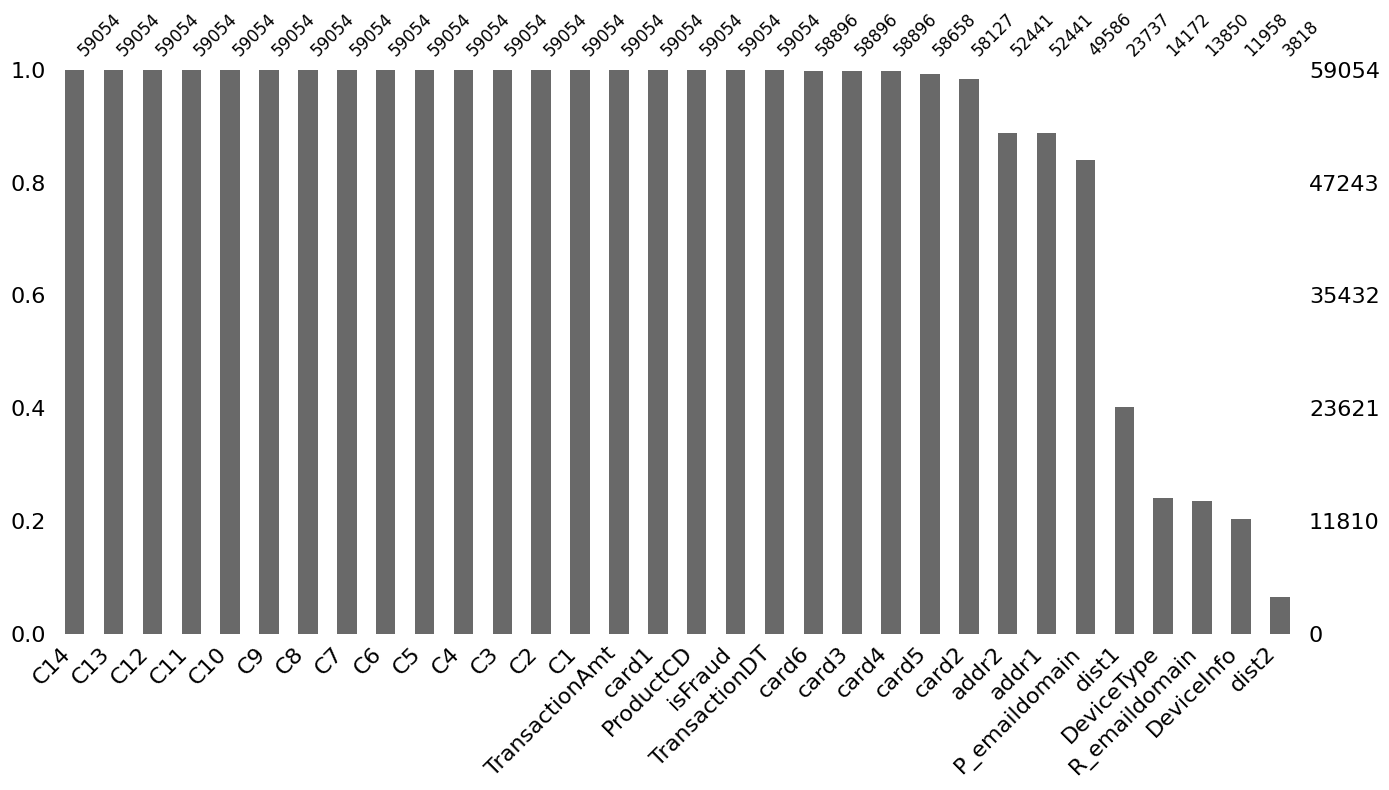

In [90]:
import matplotlib.pyplot as plt


# Crear la figura con el tamaño deseado
plt.figure(figsize=(14, 8))

# Generar el gráfico de barras de valores nulos
msno.bar(df_train, sort='descending')

# Ajustar el tamaño de las etiquetas de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Obtener la figura actual y ajustar el tamaño
fig = plt.gcf()
fig.set_size_inches(14, 8)  # Asegurarse de que el tamaño de la figura sea adecuado

# Ajustar los márgenes para evitar que las etiquetas se recorten
plt.tight_layout()

# Guardar la figura en un archivo PNG
#plt.savefig(base_dir + 'nulos.png')

# Mostrar la figura
plt.show()


En el gráfico de arriba se presenta una visualización de la cantidad de valores nulos en forma descendente. Destacan especialmente cinco atributos con una significativa cantidad de valores nulos: 'dist1', 'DeviceType', 'R_emaildomain', 'DeviceInfo' y 'dist2'. Esta distribución nos ofrece una instantánea clara de las áreas de nuestros datos que pueden requerir mayor atención y manejo especial durante el proceso de limpieza y preparación de los datos.

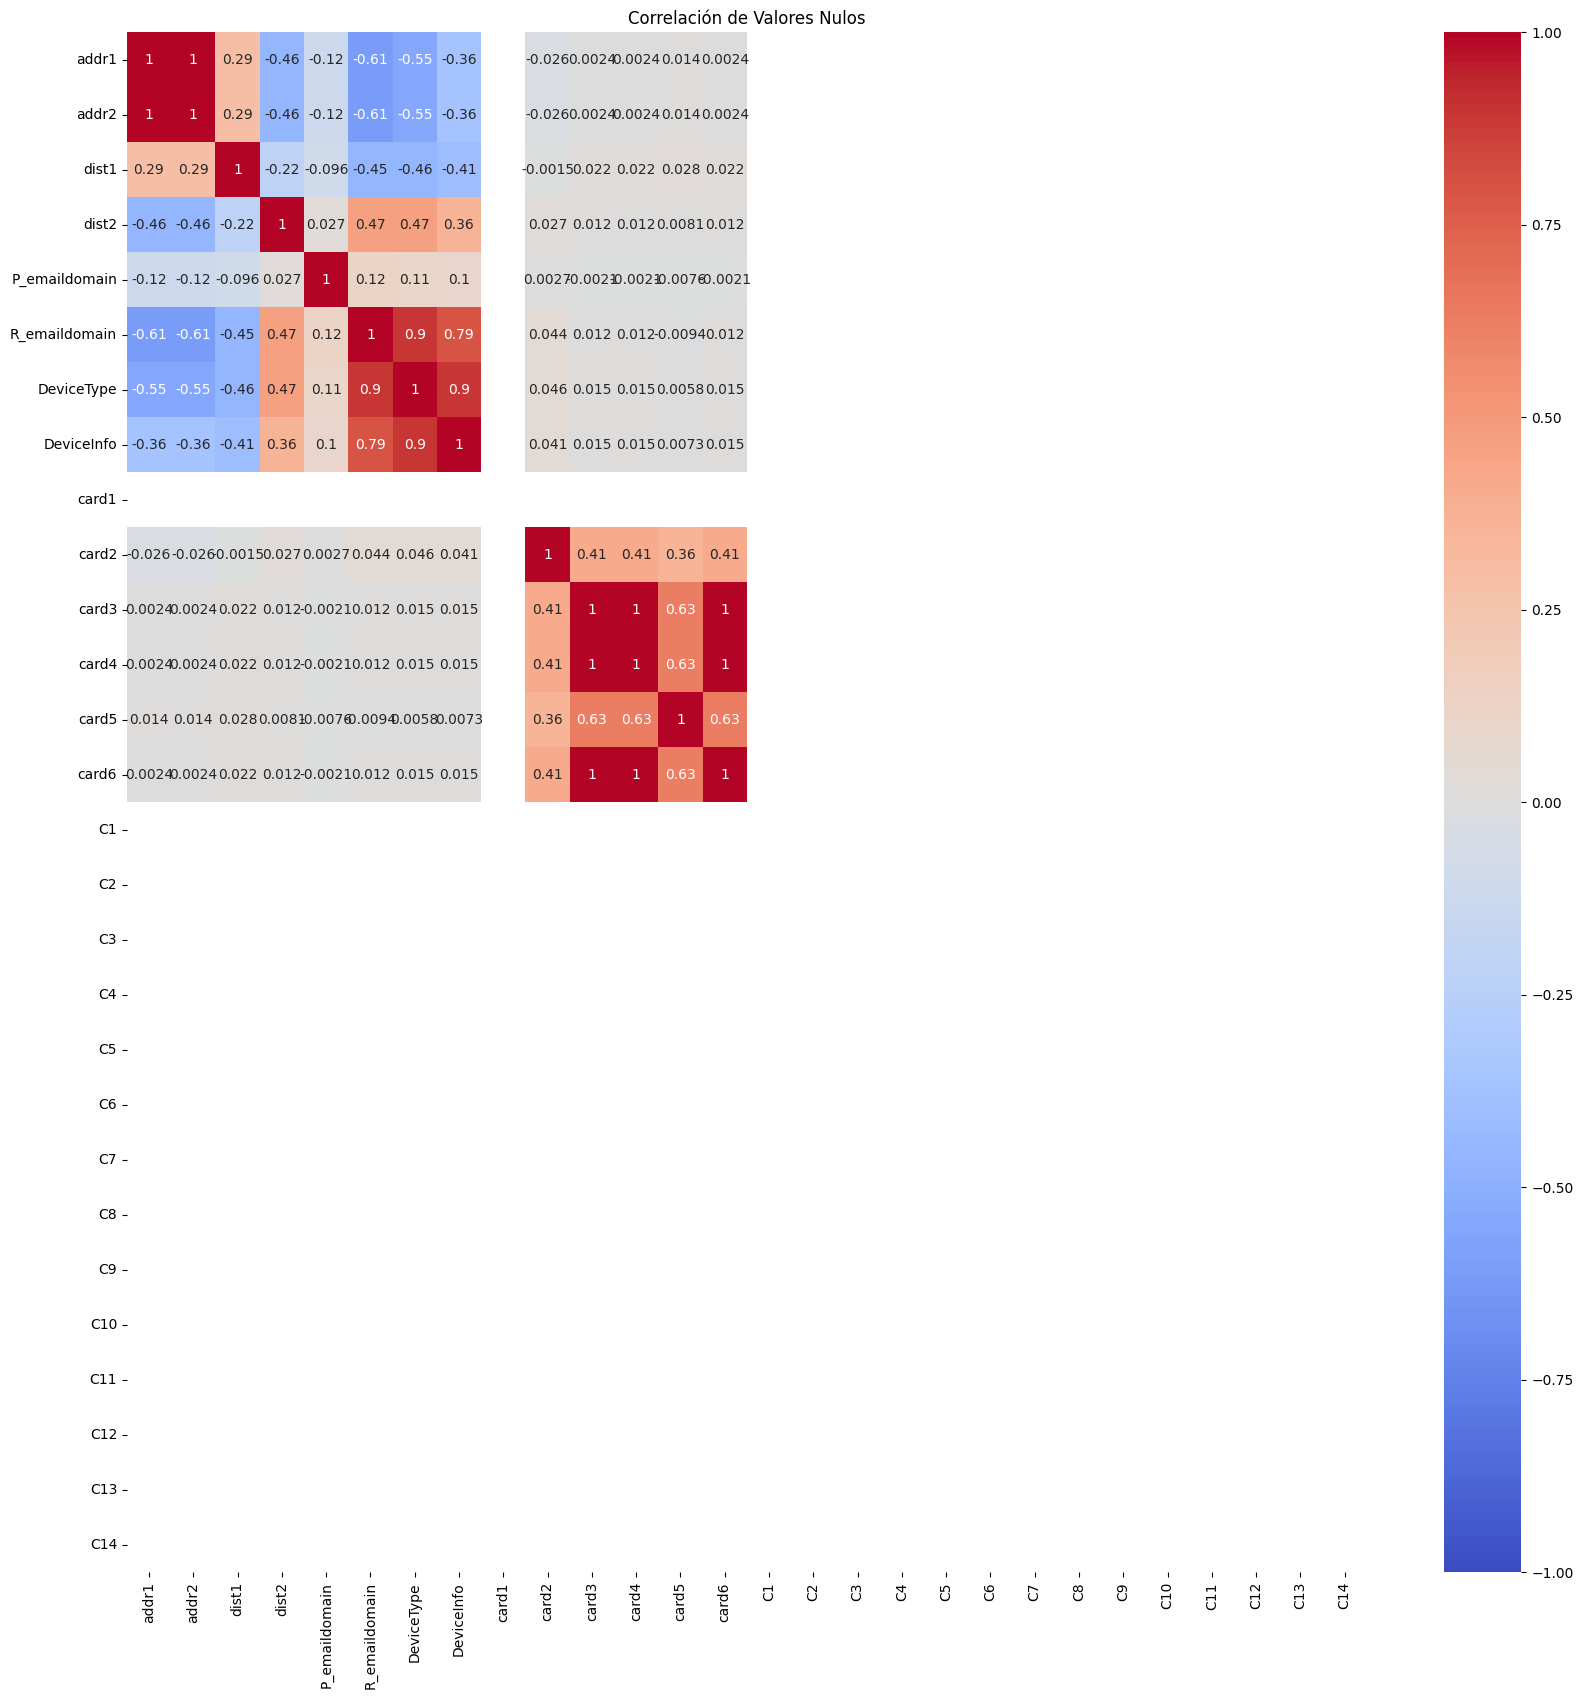

In [91]:
df_nulls = df_train.isnull().drop(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD'],axis=1)

# Calcular la correlación entre los valores nulos
corr_nulls = df_nulls.corr()

# Crear el mapa de calor
plt.figure(figsize=(20, 20))
sns.heatmap(corr_nulls, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación de Valores Nulos')
plt.show()

In [92]:


# Suponiendo que ya tienes cargado tu dataset en 'df_train'

# Crear una nueva DataFrame booleano indicando valores nulos
df_nulls = df_train.isnull()

# Calcular la correlación entre los valores nulos
corr_nulls = df_nulls.corr()

# Obtener triángulo superior de la matriz de correlación (sin la diagonal principal)
upper_triangle = corr_nulls.where(np.triu(np.ones(corr_nulls.shape), k=1).astype(bool))

# Definir umbral de correlación
threshold = 0.5

# Filtrar pares de variables con correlación mayor que el umbral
high_corr_pairs = upper_triangle[upper_triangle.abs() > threshold].stack().reset_index()
high_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlación']

# Mostrar los pares de variables con alta correlación ordenados por la correlación
high_corr_pairs_sorted = high_corr_pairs.sort_values(by='Correlación', ascending=False)
print(high_corr_pairs_sorted)


       Variable 1     Variable 2  Correlación
0           addr1          addr2     1.000000
8           card3          card4     1.000000
10          card3          card6     1.000000
12          card4          card6     1.000000
5   R_emaildomain     DeviceType     0.897175
7      DeviceType     DeviceInfo     0.896130
6   R_emaildomain     DeviceInfo     0.793478
9           card3          card5     0.630379
11          card4          card5     0.630379
13          card5          card6     0.630379
2           addr1     DeviceType    -0.549595
4           addr2     DeviceType    -0.549595
3           addr2  R_emaildomain    -0.611382
1           addr1  R_emaildomain    -0.611382


En la tabla anterior, se observa que los datos nulos muestran una correlación significativa entre ellos, con valores superiores a 0.5 en términos absolutos. Por ejemplo, addr1 y addr2, que representan la región y el país de facturación respectivamente para el comprador, muestran una posible relación de nulidad entre sí, dado que ambos son atributos de la dirección del comprador.

Todas las demás variables también muestran una alta correlación de datos nulos, reflejada en la gran cantidad de valores ausentes para cada variable, lo cual contribuye a un alto valor de correlación entre ellas.


### Eliminamos las columnas con más del 80% de valores nulos

In [93]:
df_train.drop(['dist1','DeviceType','R_emaildomain','DeviceInfo','dist2'], axis=1,inplace=True)

In [94]:
null_percentages = (df_train.isnull().sum() / len(df_train)) * 100
print(round(null_percentages,2))

isFraud            0.00
TransactionDT      0.00
TransactionAmt     0.00
ProductCD          0.00
addr1             11.20
addr2             11.20
P_emaildomain     16.03
card1              0.00
card2              1.57
card3              0.27
card4              0.27
card5              0.67
card6              0.27
C1                 0.00
C2                 0.00
C3                 0.00
C4                 0.00
C5                 0.00
C6                 0.00
C7                 0.00
C8                 0.00
C9                 0.00
C10                0.00
C11                0.00
C12                0.00
C13                0.00
C14                0.00
dtype: float64


### Valores Duplicados

In [95]:
df_train[df_train.duplicated(keep=False)].count()

isFraud           0
TransactionDT     0
TransactionAmt    0
ProductCD         0
addr1             0
addr2             0
P_emaildomain     0
card1             0
card2             0
card3             0
card4             0
card5             0
card6             0
C1                0
C2                0
C3                0
C4                0
C5                0
C6                0
C7                0
C8                0
C9                0
C10               0
C11               0
C12               0
C13               0
C14               0
dtype: int64

Debido a la baja presencia de valores duplicados, procederemos a eliminarlos del dataset.



In [96]:
df_train = df_train.dropna()
df_train[df_train.duplicated(keep=False)].count()

isFraud           0
TransactionDT     0
TransactionAmt    0
ProductCD         0
addr1             0
addr2             0
P_emaildomain     0
card1             0
card2             0
card3             0
card4             0
card5             0
card6             0
C1                0
C2                0
C3                0
C4                0
C5                0
C6                0
C7                0
C8                0
C9                0
C10               0
C11               0
C12               0
C13               0
C14               0
dtype: int64

## Análisis Univariado

### Columna Target 'isFraud'

Comenzamos el análisis focalizándonos en la columna "isFraud", ya que representa el resultado de nuestros predictores o características. Evaluamos la cantidad de registros y representaremos visualmente esta información mediante un gráfico de barras, con el propósito de ilustrar la cantidad de registros clasificados como fraude y aquellos que no lo son.

In [97]:
df_train['isFraud'] = df_train['isFraud'].replace({0: 'No', 1: 'Sí'})

/tmp/ipykernel_13590/1317669067.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fraude, x='isFraud', y='count', palette=['tab:blue', 'tab:red'], ax=ax)


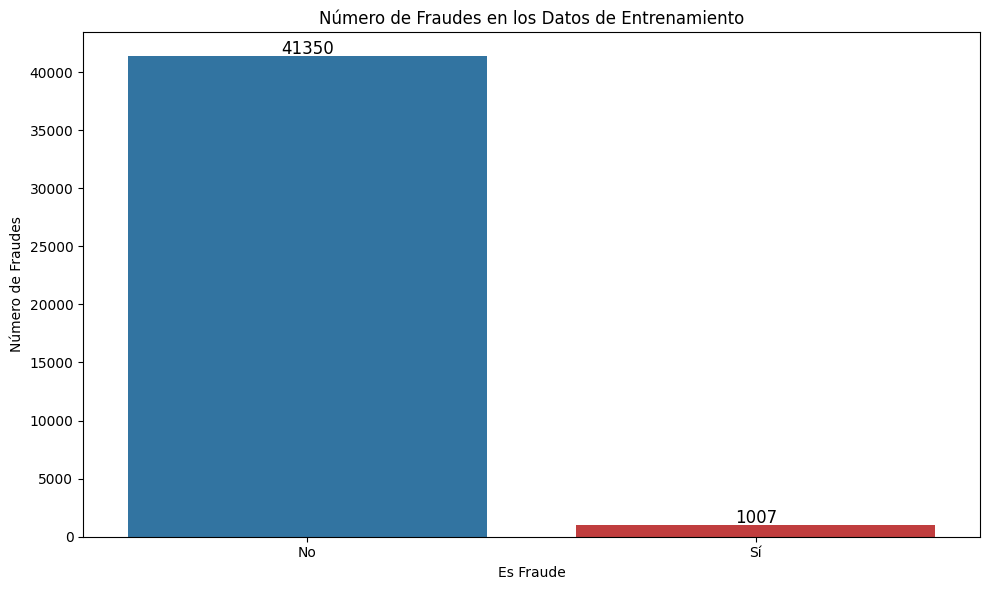

In [98]:
# Calcular los números de fraudes en los datos de entrenamiento
Numero_fraude = df_train.isFraud.value_counts()
df_fraude = pd.DataFrame(Numero_fraude).rename(index={0: 'No', 1: 'Sí'})
df_fraude.reset_index(inplace=True)
df_fraude.columns = ['isFraud', 'count']  # Renombrar columnas para usar en seaborn

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(10, 6))

# Crear el gráfico de barras
sns.barplot(data=df_fraude, x='isFraud', y='count', palette=['tab:blue', 'tab:red'], ax=ax)

# Etiquetas y título
ax.set_ylabel('Número de Fraudes')
ax.set_title('Número de Fraudes en los Datos de Entrenamiento')
ax.set_xlabel('Es Fraude')

# Añadir etiquetas a las barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()

# Guardar la figura
#plt.savefig(base_dir + 'balance_datos.png')

# Mostrar la figura
plt.show()


In [99]:


# Calcular los porcentajes de fraudes en los datos de entrenamiento
porcentaje_fraude = df_train['isFraud'].value_counts(normalize=True) * 100

# Crear un DataFrame con los porcentajes
df_porcentaje_fraude = pd.DataFrame(porcentaje_fraude)

# Renombrar las columnas
df_porcentaje_fraude.columns = ['Porcentaje']

# Restaurar los índices originales
df_porcentaje_fraude.reset_index(inplace=True)

# Renombrar las categorías
df_porcentaje_fraude['isFraud'] = df_porcentaje_fraude['isFraud'].map({0: 'No', 1: 'Sí'})

# Mostrar el DataFrame
df_porcentaje_fraude


,isFraud,Porcentaje
0,NaN,97.622589
1,NaN,2.377411


Obervación:
**Cantidad de registros por archivo**

| Es Fraude | N° de Registros |
| ------------ | ------------ |
| No| 96,45%|
| Sí| 3.54%|

Se destaca que la mayoría abrumadora de las transacciones se encuentran en la categoría no fraudulenta, mientras que solo una fracción mínima corresponde a casos de fraude. Este desbalance en los datos puede representar un desafío significativo para el proceso de aprendizaje automático, ya que los modelos pueden tener dificultades para identificar y aprender patrones en las clases minoritarias debido a su escasez relativa

### Análisis de las caracteterísticas

### Columna Importe del pago por transacción en USD (TransactionAmt)


Analizamos la asociación entre la columna "TransactionAmt", que representa los importes de cada transacción, y la columna de fraude. Este análisis incluye la evaluación de la distribución de los montos en relación con la presencia de fraudes.



In [100]:
df_train[['TransactionAmt']].describe().round(2)

,TransactionAmt
count,42357.00
mean,151.23
std,291.59
min,1.53
25%,49.00
50%,87.95
75%,150.00
max,31937.39


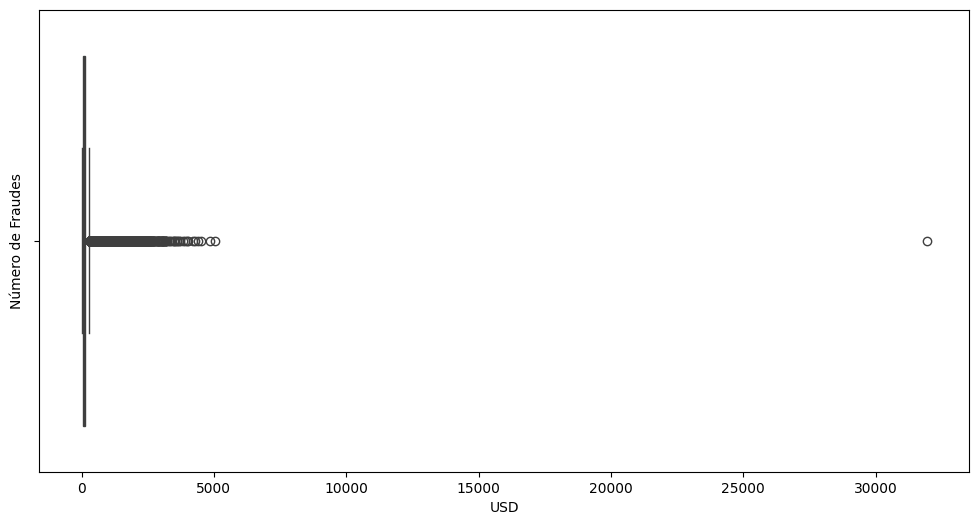

In [101]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_train, x='TransactionAmt')
plt.ylabel('Número de Fraudes')
plt.xlabel('USD')
#plt.savefig(base_dir + 'trabs_total_box_plot')
plt.show()

El valor medio de la variable 'TransactionAmt' es de 134.5, con una desviación estándar de 263.63. Además, el valor máximo está considerablemente alejado del tercer quartil del 75%  de los datos, lo que indica la presencia de valores atípicos en esta característica, en el gráfico de arriba se pued apreciar con mas detalle la exitencia de valores atípicos.

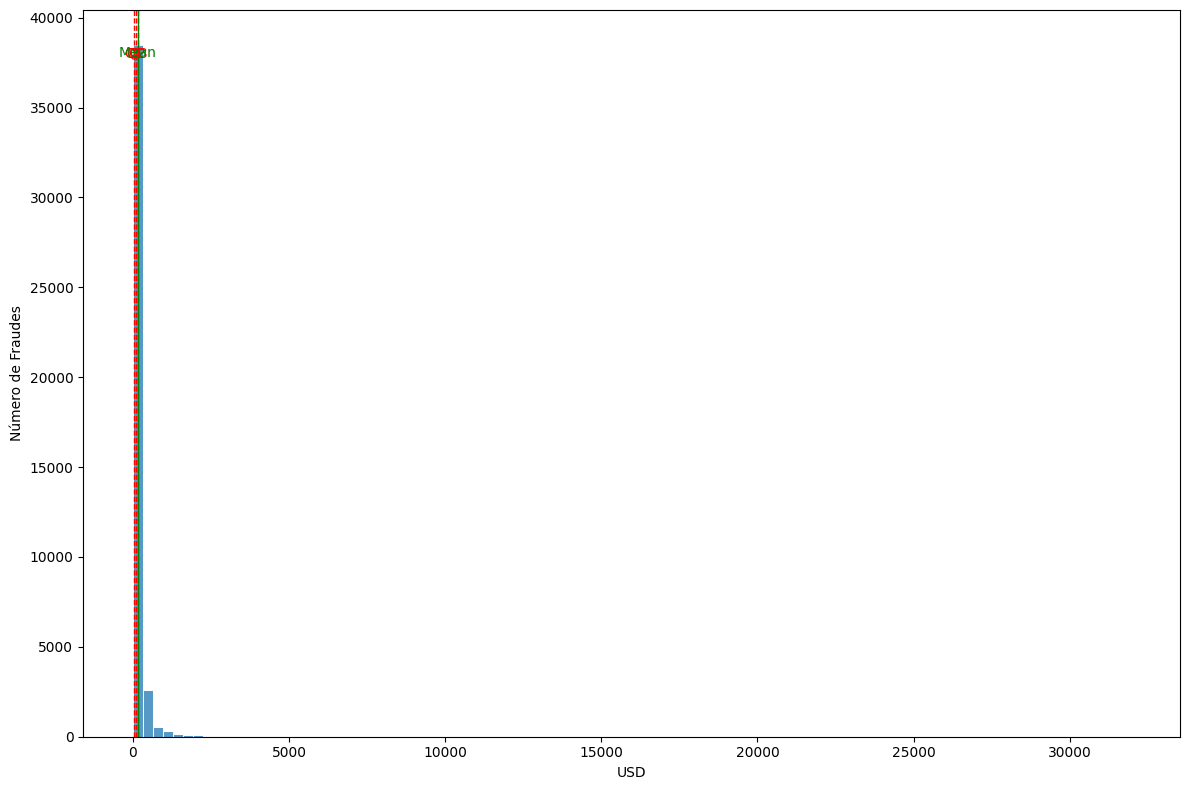

In [102]:
quartiles = np.percentile(df_train['TransactionAmt'], [25, 50, 75])
mean_value = df_train['TransactionAmt'].mean()

fig, axs = plt.subplots(tight_layout=True, figsize=(12, 8))

# Crear el histograma
sns.histplot(data=df_train, x='TransactionAmt', bins=100, color='tab:blue', edgecolor="white", linewidth=0.7, label='No', log_scale=False, ax=axs)

# Añadir líneas de los cuartiles
for q in quartiles:
    axs.axvline(q, color='red', linestyle='--', linewidth=1)

# Añadir línea de la media
axs.axvline(mean_value, color='green', linestyle='-', linewidth=1)

# Etiquetas y título
axs.set_ylabel('Número de Fraudes')
axs.set_xlabel('USD')

# Añadir leyenda para los cuartiles y la media
quartile_labels = ['Q1', 'Q2', 'Q3']
for i, q in enumerate(quartiles):
    axs.text(q, axs.get_ylim()[1] * 0.95, quartile_labels[i], color='red', ha='center', va='top')
axs.text(mean_value, axs.get_ylim()[1] * 0.95, 'Mean', color='green', ha='center', va='top')

plt.show()

#### Vemos ahora estos valores en escala logarítmicas

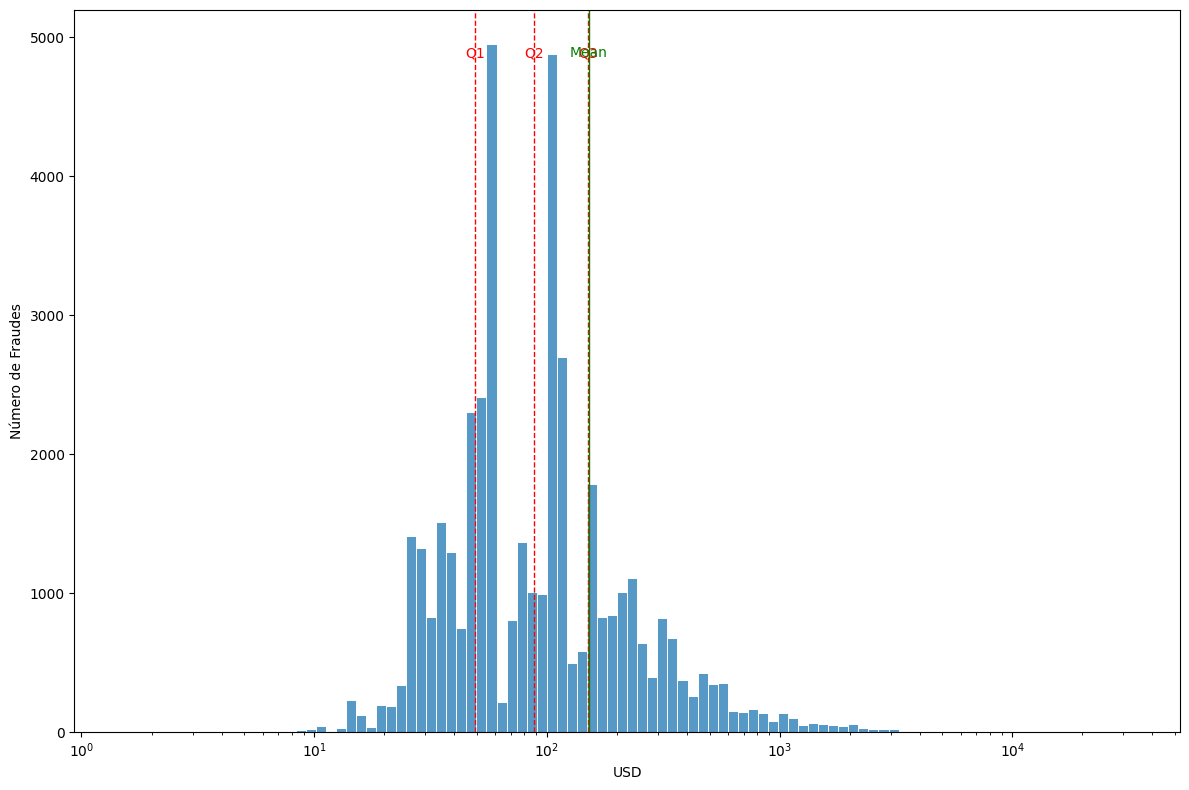

In [103]:
quartiles = np.percentile(df_train['TransactionAmt'], [25, 50, 75])
mean_value = df_train['TransactionAmt'].mean()

fig, axs = plt.subplots(tight_layout=True, figsize=(12, 8))

# Crear el histograma
sns.histplot(data=df_train, x='TransactionAmt', bins=100, color='tab:blue', edgecolor="white", linewidth=0.7, label='No', log_scale=True, ax=axs)

# Añadir líneas de los cuartiles
for q in quartiles:
    axs.axvline(q, color='red', linestyle='--', linewidth=1)

# Añadir línea de la media
axs.axvline(mean_value, color='green', linestyle='-', linewidth=1)

# Etiquetas y título
axs.set_ylabel('Número de Fraudes')
axs.set_xlabel('USD')

# Añadir leyenda para los cuartiles y la media
quartile_labels = ['Q1', 'Q2', 'Q3']
for i, q in enumerate(quartiles):
    axs.text(q, axs.get_ylim()[1] * 0.95, quartile_labels[i], color='red', ha='center', va='top')
axs.text(mean_value, axs.get_ylim()[1] * 0.95, 'Mean', color='green', ha='center', va='top')

plt.show()

Observación:

En la representación gráfica de la distribución y en la tabla de estadísticos asociada a la columna "TransactionAmt", se destacan las siguientes observaciones:

- Se evidencia una notable disparidad de la mediana (Q2) con el valor medio de los valores de TransactionAmt.
- El valor medio casi coincide con el los 75% de  valores (Q3) esto señale la gran dispersión de los valores.


La comparación entre el límite superior del rango intercuartil y el valor máximo revela discrepancias significativas en órdenes de magnitud, indicando la presencia de datos atípicos.

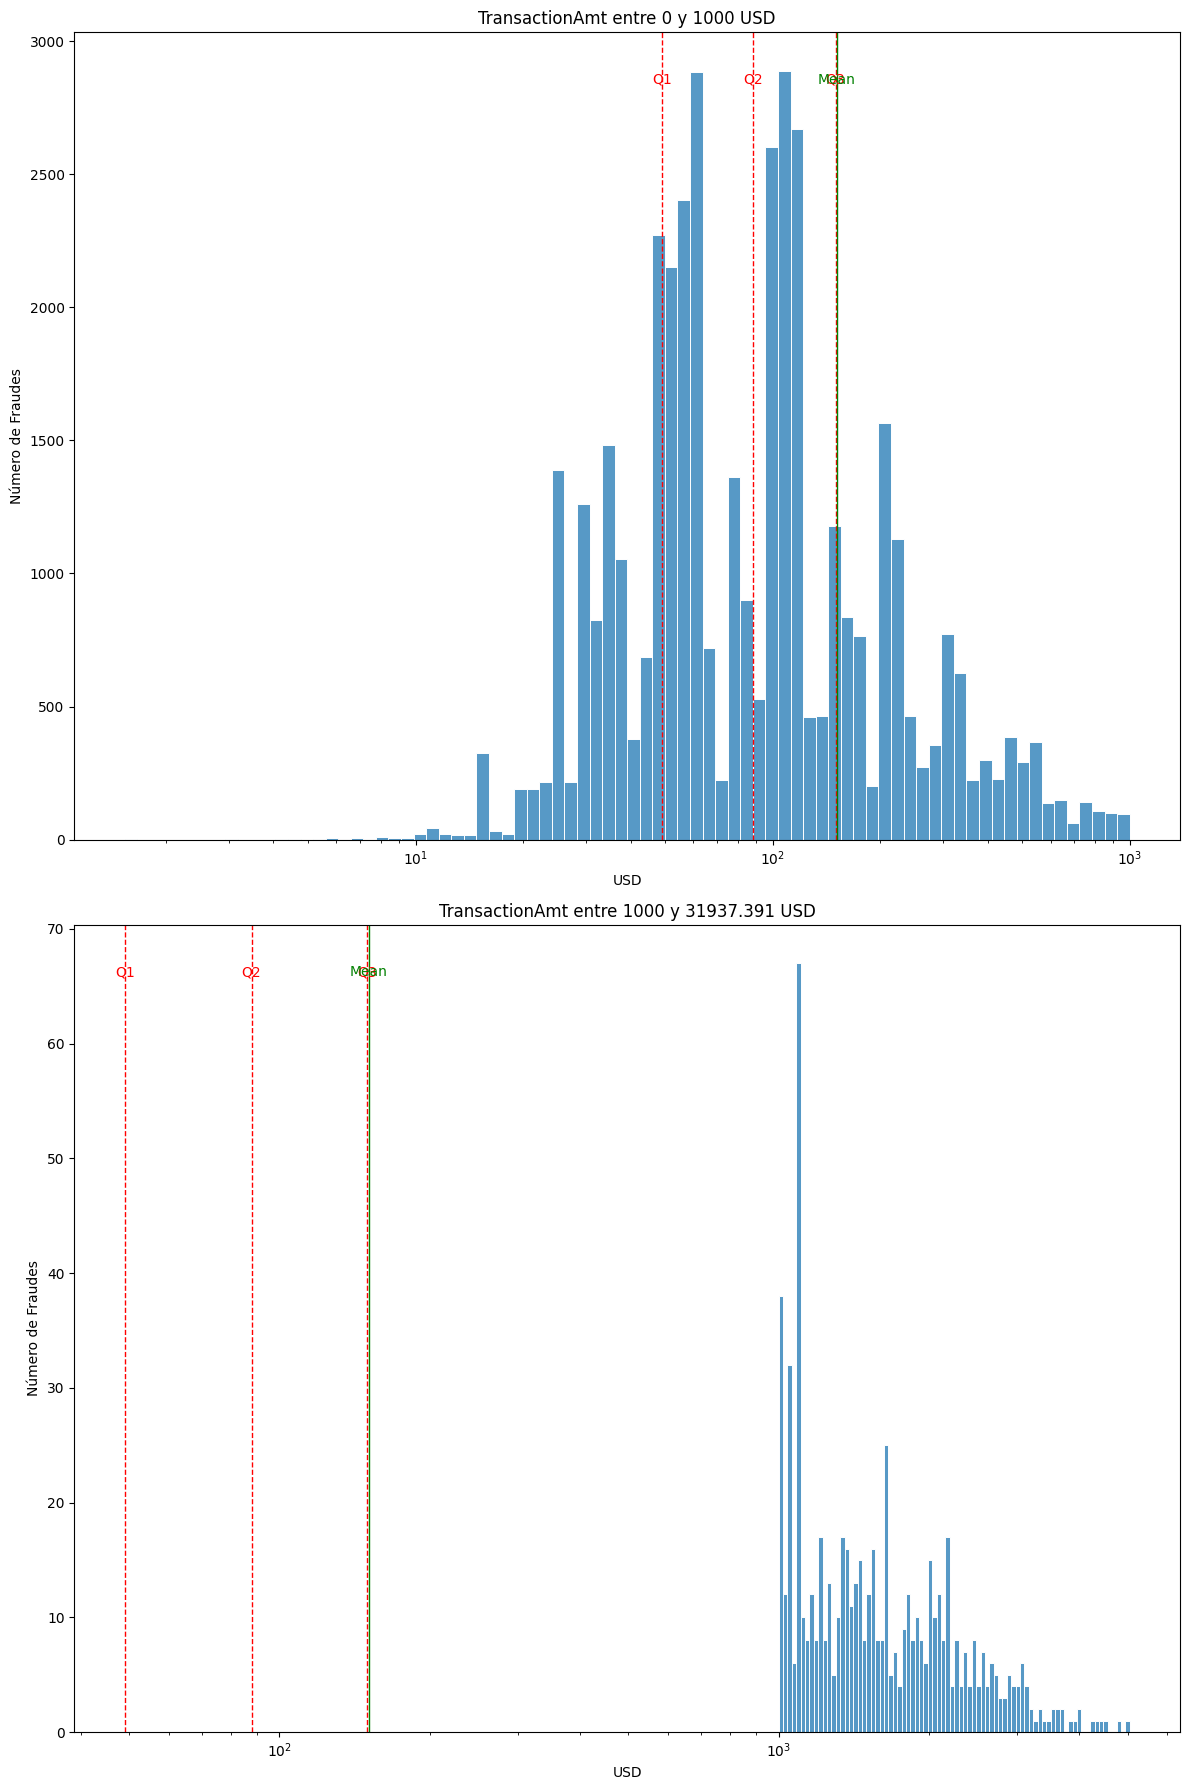

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir los rangos para 'TransactionAmt'
ranges = [(0, 1000),(1000, df_train['TransactionAmt'].max())]

# Crear la figura y los subplots
fig, axs = plt.subplots(nrows=2, tight_layout=True, figsize=(12, 18))

# Generar el histograma para cada rango
for ax, (min_val, max_val) in zip(axs, ranges):
    subset = df_train[(df_train['TransactionAmt'] >= min_val) & (df_train['TransactionAmt'] < max_val)]
    sns.histplot(data=subset, x='TransactionAmt', bins=80, color='tab:blue', edgecolor="white", linewidth=0.7, label='No', ax=ax, log_scale=True)
    ax.set_title(f'TransactionAmt entre {min_val} y {max_val} USD')
    ax.set_ylabel('Número de Fraudes')
    ax.set_xlabel('USD')
    # Añadir líneas de los cuartiles
    for q in quartiles:
        ax.axvline(q, color='red', linestyle='--', linewidth=1)
    
    # Añadir línea de la media
    ax.axvline(mean_value, color='green', linestyle='-', linewidth=1)
    
    # Etiquetas y título
    ax.set_ylabel('Número de Fraudes')
    ax.set_xlabel('USD')
    
    # Añadir leyenda para los cuartiles y la media
    quartile_labels = ['Q1', 'Q2', 'Q3']
    for i, q in enumerate(quartiles):
        ax.text(q, ax.get_ylim()[1] * 0.95, quartile_labels[i], color='red', ha='center', va='top')
    ax.text(mean_value, ax.get_ylim()[1] * 0.95, 'Mean', color='green', ha='center', va='top')

    

plt.show()


Separamos el histograma en dos rangos de valores: uno de 0 a 1000 y otro de 1000 hasta el valor máximo. Al observar cada rango, notamos que presentan distribuciones diferentes, lo cual indica una posible segmentación en esta característica.

### Separación de los datos por rango de la columna de (TransactionAmt)

In [105]:

# Calcular los cuartiles y el IQR
Q1 = np.percentile(df_train['TransactionAmt'], 25)
Q3 = np.percentile(df_train['TransactionAmt'], 75)
IQR = Q3 - Q1

# Definir los umbrales para valores atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Función para clasificar los valores en rangos
def classify_transaction_amt(value):
    if value < lower_bound:
        return 'Muy bajo'
    elif lower_bound <= value < Q1:
        return 'Bajo'
    elif Q1 <= value < Q3:
        return 'Medio'
    elif Q3 <= value < upper_bound:
        return 'Alto'
    else:
        return 'Muy alto'

# Aplicar la función de clasificación a la columna
df_train['TransactionAmt_Range'] = df_train['TransactionAmt'].apply(classify_transaction_amt)

# Mostrar algunos resultados
print(df_train['TransactionAmt_Range'].value_counts())


TransactionAmt_Range
Medio       21742
Bajo         9426
Alto         6819
Muy alto     4370
Name: count, dtype: int64


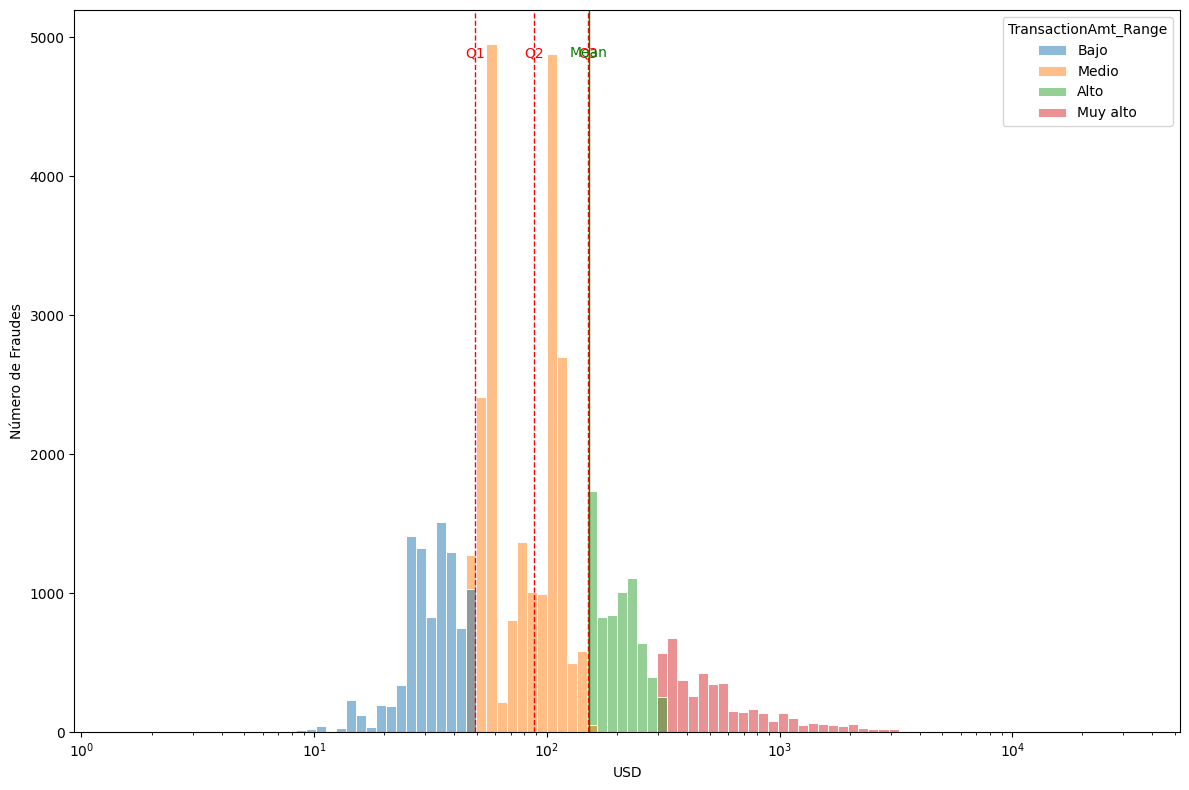

In [106]:
quartiles = np.percentile(df_train['TransactionAmt'], [25, 50, 75])
mean_value = df_train['TransactionAmt'].mean()

fig, axs = plt.subplots(tight_layout=True, figsize=(12, 8))

# Crear el histograma
sns.histplot(data=df_train, x='TransactionAmt', bins=100, color='tab:blue', 
             edgecolor="white", linewidth=0.7, label='No', log_scale=True, ax=axs,hue='TransactionAmt_Range')

# Añadir líneas de los cuartiles
for q in quartiles:
    axs.axvline(q, color='red', linestyle='--', linewidth=1)

# Añadir línea de la media
axs.axvline(mean_value, color='green', linestyle='-', linewidth=1)

# Etiquetas y título
axs.set_ylabel('Número de Fraudes')
axs.set_xlabel('USD')

# Añadir leyenda para los cuartiles y la media
quartile_labels = ['Q1', 'Q2', 'Q3']
for i, q in enumerate(quartiles):
    axs.text(q, axs.get_ylim()[1] * 0.95, quartile_labels[i], color='red', ha='center', va='top')
axs.text(mean_value, axs.get_ylim()[1] * 0.95, 'Mean', color='green', ha='center', va='top')

plt.show()

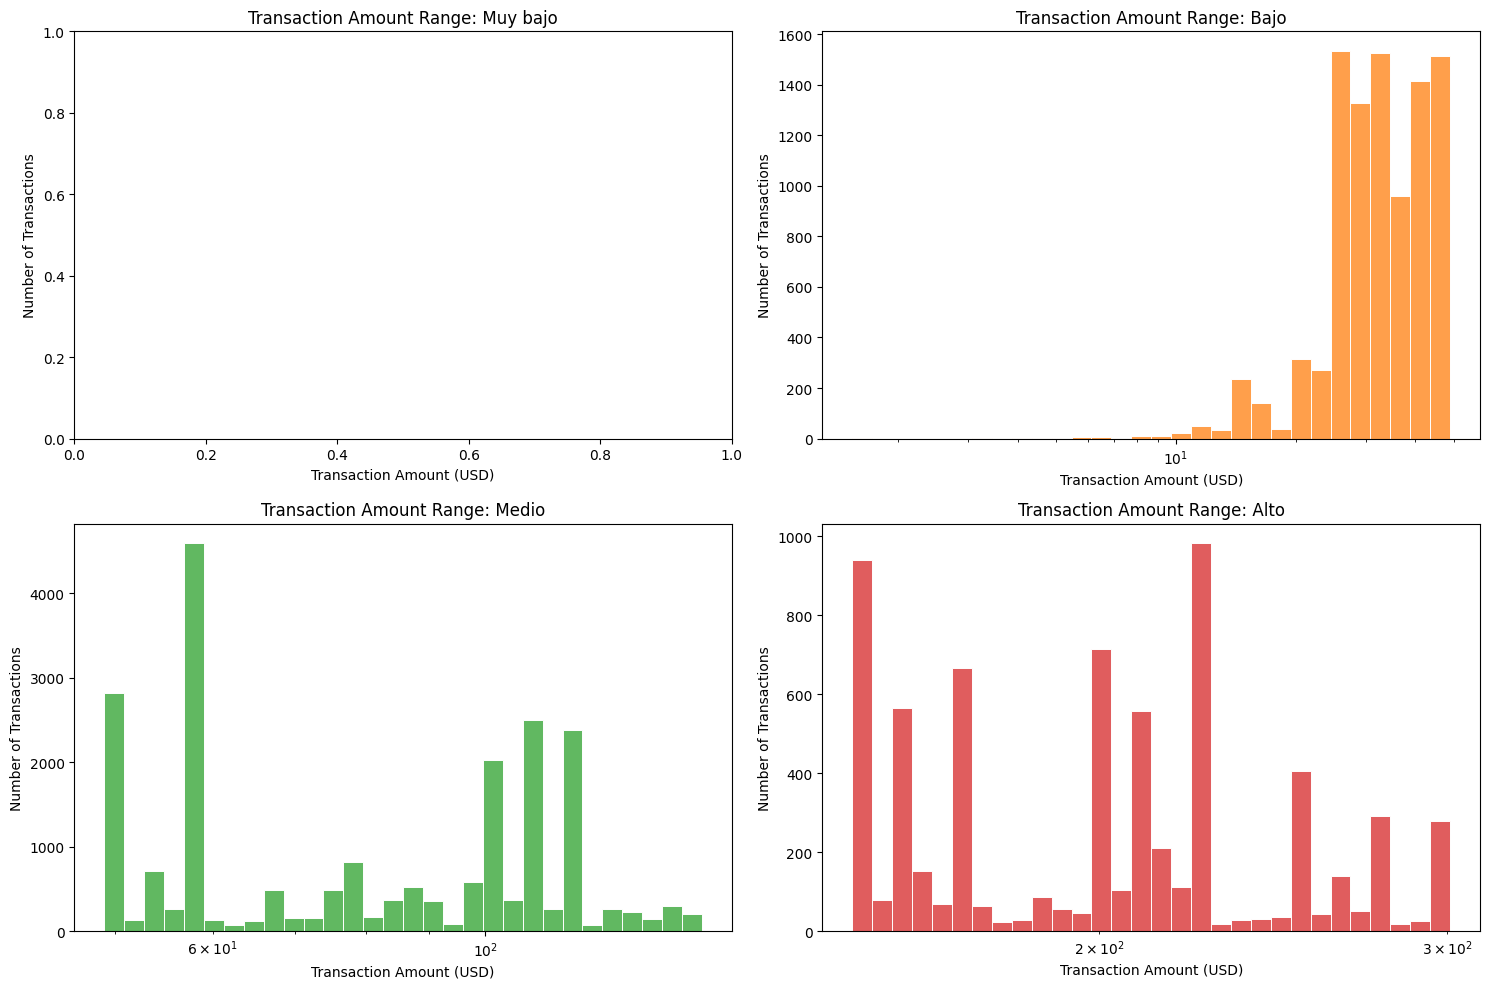

In [107]:

# Crear subplots para cada rango de valor
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharey=False, tight_layout=True)

# Definir los nombres de los rangos y los colores correspondientes
range_labels = ['Muy bajo', 'Bajo', 'Medio', 'Alto']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Iterar sobre los subplots y los rangos
for i, ax in enumerate(axs.flatten()):
    range_label = range_labels[i]
    color = colors[i]

    # Filtrar datos para el rango actual
    subset_data = df_train[df_train['TransactionAmt_Range'] == range_label]

    # Verificar si hay datos en el subset
    if not subset_data.empty:
        # Calcular el número de transacciones en el rango actual
        num_transactions = len(subset_data)

        # Crear el histograma para el rango actual
        sns.histplot(data=subset_data, x='TransactionAmt', bins=30, color=color,
                     edgecolor="white", linewidth=0.7, log_scale=True, ax=ax)

        ax.set_ylim(bottom=0)

    # Etiquetas y título para cada subplot
    ax.set_title(f'Transaction Amount Range: {range_label}')
    ax.set_xlabel('Transaction Amount (USD)')
    ax.set_ylabel('Number of Transactions')

# Ajustar el espacio entre subplots y mostrar la figura
plt.tight_layout()
plt.show()

- Cada valor en la columna TransactionAmt se clasifica en uno de los rangos definidos (Muy bajo, Bajo, Medio, Alto, Muy alto) según los cuartiles y los límites de valores atípicos. Se crea una nueva columna llamada TransactionAmt_Range en el DataFrame, que contiene el rango correspondiente para cada valor de TransactionAmt.
- No hay datos clasificados en la categoría "Muy Bajo".
- La columna TransactionAmt será reemplazada por TransactionAmt_Range ya que ambas contienen esencialmente la misma información. La columna TransactionAmt tiene valores que varían considerablemente entre diferentes rangos, lo cual dificultaría la normalización y complicaría el entrenamiento de los modelos. Por lo tanto, TransactionAmt será eliminada y reemplazada por TransactionAmt_Range que tiene las categorías separadas por rangos.

### Columna Intervalo de tiempo (**TransactionDT**)

**TransactionDT**: timedelta desde una fecha de referencia dada (no es una marca de tiempo real).
- "El primer valor de TransactionDT es 86400, que corresponde al número de segundos en un día (60 * 60 * 24 = 86400), por lo que creo que la unidad es segundos. Usando esto, sabemos que los datos abarcan 6 meses, ya que el valor máximo es 15811131, lo que correspondería al día 183."

In [108]:
df_train[['TransactionDT']].describe().round(2)

,TransactionDT
count,42357.00
mean,7333151.24
std,4617205.45
min,86469.00
25%,2968147.00
50%,7313957.00
75%,11145404.00
max,15810935.00


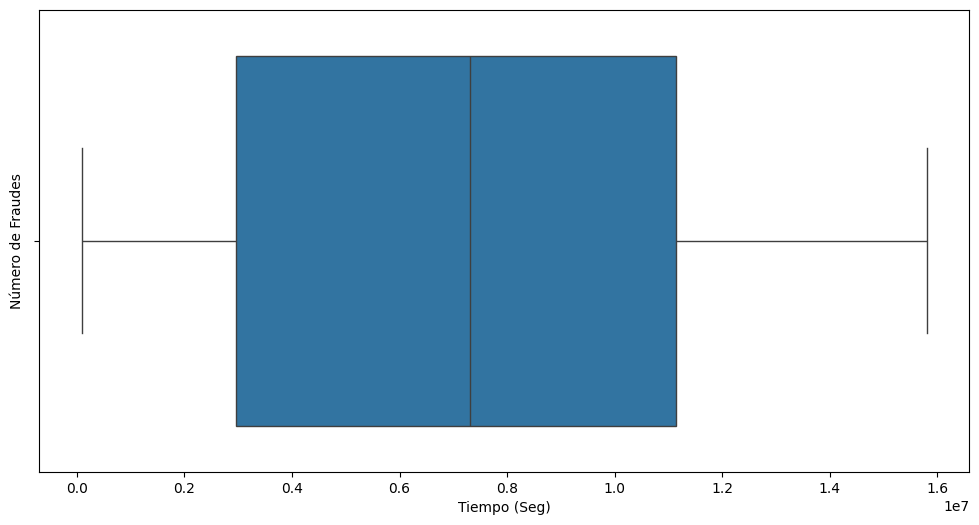

In [109]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_train, x='TransactionDT')
plt.ylabel('Número de Fraudes')
plt.xlabel('Tiempo (Seg)')
#plt.savefig(base_dir + 'trabs_total_box_plot')
plt.show()

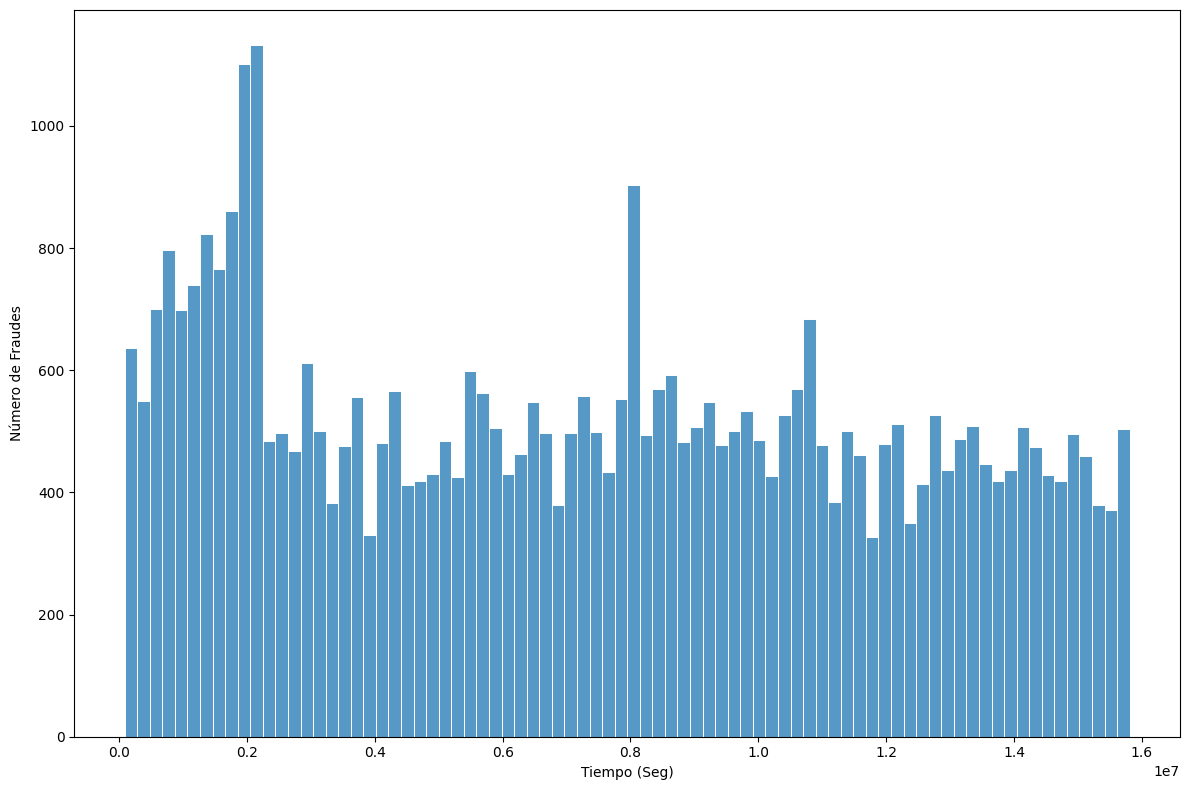

In [110]:
fig, axs = plt.subplots(tight_layout=True, figsize=(12, 8))

sns.histplot(data=df_train, x='TransactionDT', bins=80, color='tab:blue', edgecolor="white", linewidth=0.7, label='No')
axs.set_ylabel('Número de Fraudes')
axs.set_xlabel('Tiempo (Seg)')

plt.show()


**Observación:** La distribución de los tiempo de transacción es casi uniforme, aunuque se observa que algunos tiempo de transacciones son más frecuente que otros.

### Columna ProductCD

**ProductCD**: código de producto, el producto para cada transacción.
- "El producto no necesariamente tiene que ser un 'producto' real (como un artículo para agregar al carrito de compras). Podría ser cualquier tipo de servicio."

In [111]:
df_train['ProductCD'].unique()

array(['H', 'W', 'R', 'C'], dtype=object)

/tmp/ipykernel_13590/2604689525.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(productCD,ax=ax,palette="tab10")


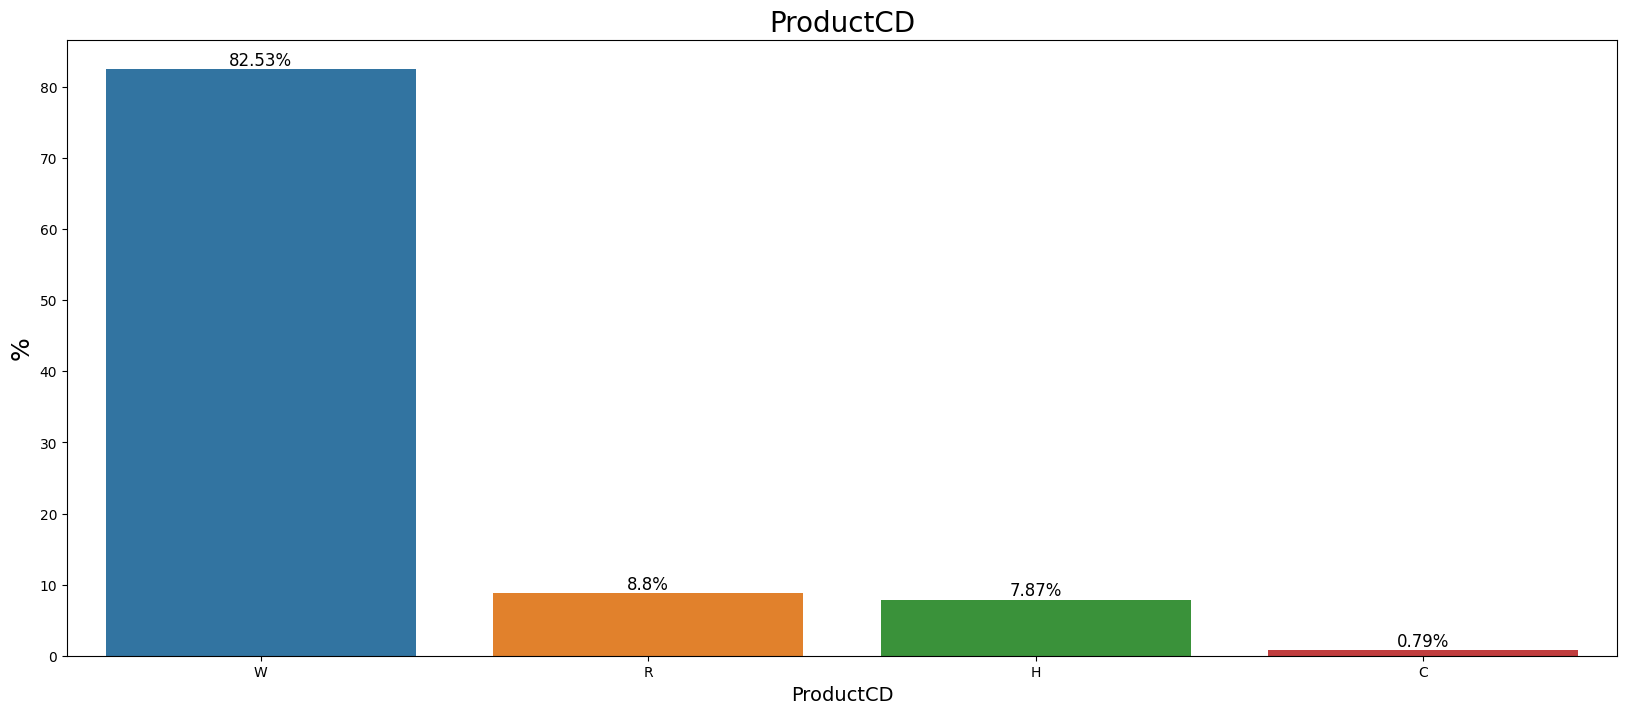

In [112]:
productCD = round((df_train['ProductCD'].value_counts()/len(df_train['ProductCD']))*100,2)
fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(productCD,ax=ax,palette="tab10")
plt.title('ProductCD', fontsize=20)
plt.xlabel('ProductCD', fontsize=14)
plt.ylabel('%', fontsize=18)
for container in ax.containers:
    ax.bar_label(container, fmt='%g%%', color='black', fontsize=12)
#plt.savefig(base_dir+'productcd')
plt.show()

**Observación:** El tipo de producto con mayor transacción es el "W" con 74.39%, seguido del producto "C" con 11.55%

### Característica Addr

**addr**: dirección.
- "Ambas direcciones son para el comprador: addr1 como región de facturación, addr2 como país de facturación."

In [113]:


addr = df_train.groupby(['addr1']).size()
addr_resultado = addr.reset_index(name='N° Registros')
addr_resultado['Porcentaje %'] = round((addr_resultado['N° Registros'] / addr_resultado['N° Registros'].sum()) * 100,2)
addr_resultado = addr_resultado.sort_values(by='N° Registros', ascending=False)
addr_resultado.head(5)

,addr1,N° Registros,Porcentaje %
58,299.0,4039,9.54
31,204.0,3592,8.48
65,325.0,3565,8.42
47,264.0,3246,7.66
62,315.0,1857,4.38


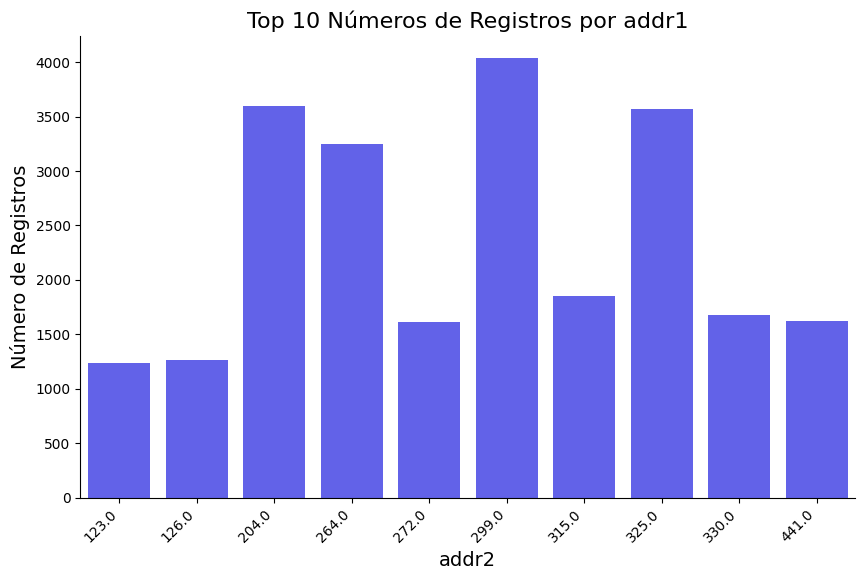

In [114]:
top_10 = addr_resultado.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='addr1', y='N° Registros', data=top_10, color='blue', alpha=0.7)
plt.title('Top 10 Números de Registros por addr1', fontsize=16)
plt.xlabel('addr2', fontsize=14)
plt.ylabel('Número de Registros', fontsize=14)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.show()


En la tabla de arriba muestra las 10 regiones con mayor transacciones 

In [115]:
addr = df_train.groupby(['addr2']).size()
addr_resultado = addr.reset_index(name='N° Registros')
addr_resultado['Porcentaje %'] = round((addr_resultado['N° Registros'] / addr_resultado['N° Registros'].sum()) * 100,2)
addr_resultado = addr_resultado.sort_values(by='N° Registros', ascending=False)
addr_resultado.head(5)

,addr2,N° Registros,Porcentaje %
25,87.0,41936,99.01
19,60.0,301,0.71
27,96.0,53,0.13
9,32.0,9,0.02
21,65.0,8,0.02


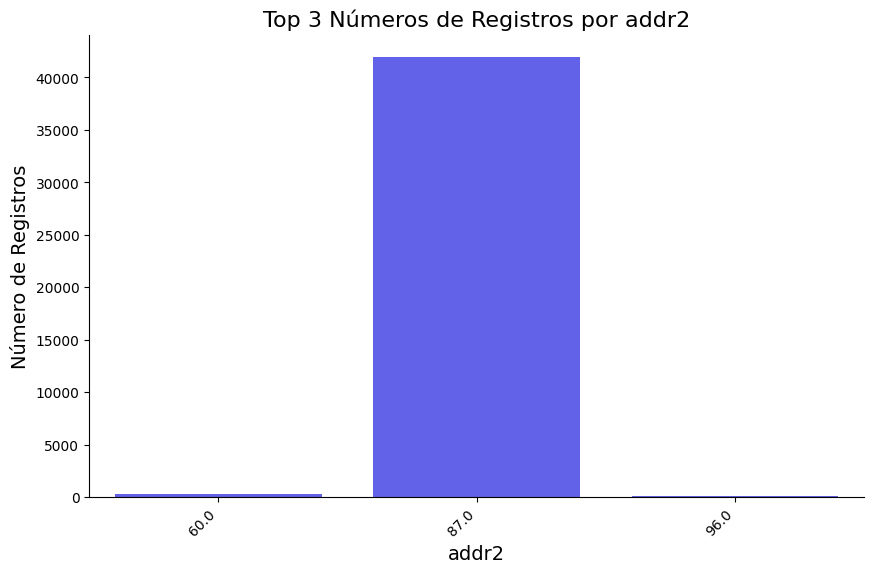

In [116]:
top_10 = addr_resultado.head(3)
plt.figure(figsize=(10, 6))
sns.barplot(x='addr2', y='N° Registros', data=top_10, color='blue', alpha=0.7)
plt.title('Top 3 Números de Registros por addr2', fontsize=16)
plt.xlabel('addr2', fontsize=14)
plt.ylabel('Número de Registros', fontsize=14)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.show()


**Obervación:**
La gráfica anterior muestra los tres países con el mayor número de transacciones. El país con el código 87 tiene la mayor cantidad de transacciones, casi el 99% de las transacciones. 


### Columna P_emaildomain 

**P_emaildomain**: dominio de correo electrónico del comprador.

In [117]:
df_train['P_emaildomain'].value_counts().head(10)

P_emaildomain
gmail.com        19829
yahoo.com         9806
anonymous.com     3067
aol.com           2761
hotmail.com       2234
comcast.net        744
icloud.com         543
msn.com            407
att.net            359
outlook.com        318
Name: count, dtype: int64

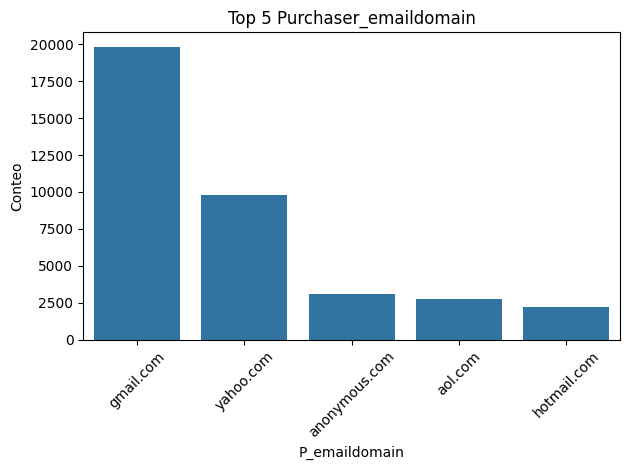

In [118]:
top_5_values = df_train['P_emaildomain'].value_counts().head(5)
sns.countplot(data=df_train, x='P_emaildomain', order=top_5_values.index)
plt.xticks(rotation=45)
plt.title('Top 5 Purchaser_emaildomain')
plt.xlabel('P_emaildomain')
plt.ylabel('Conteo')
plt.tight_layout()
#plt.savefig(base_dir+ 'emaildomaintop5')

plt.show()

**Observación:** Dominio de correo electrónico del comprador (purchaser) y del destinatario (recipient) respectivamente la mayor parte de la transacción lo hace con "gmail"

## Car


**card1 - card6**: información de la tarjeta de pago, como tipo de tarjeta, categoría de tarjeta, banco emisor, país, etc.
- "Información de la tarjeta de pago, como tipo de tarjeta, categoría de tarjeta, banco emisor, país, etc."

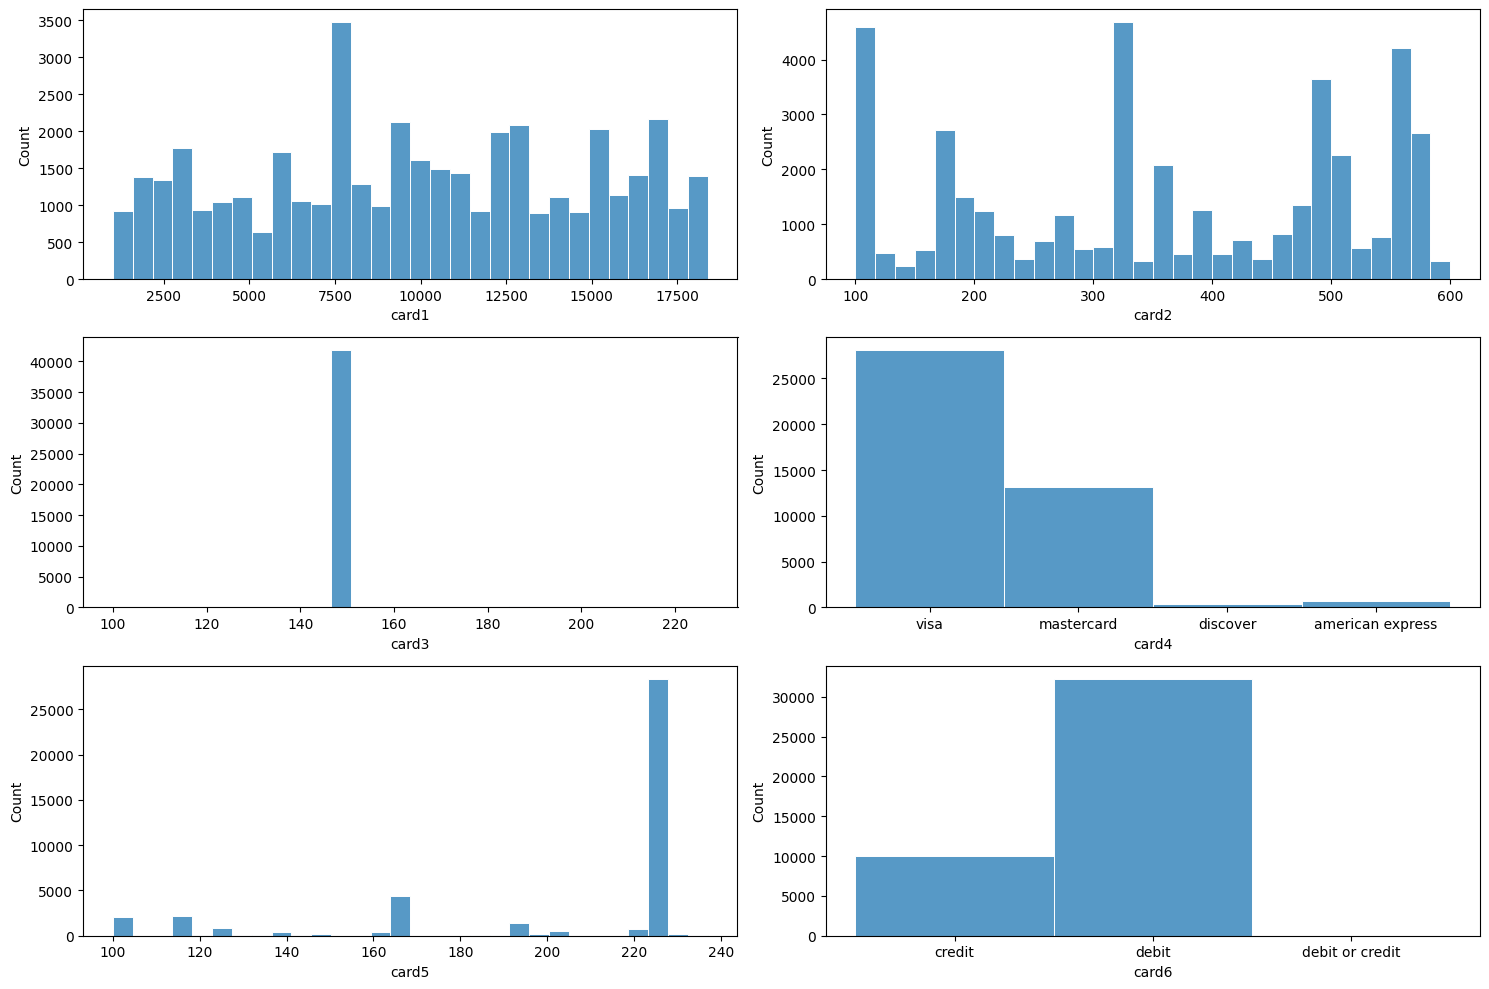

In [119]:
cards = ['card1', 'card2', 'card3', 'card4', 'card5',
       'card6']


# Crear subplots para cada rango de valor
fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharey=False, tight_layout=True)

# Iterar sobre los subplots y los rangos
for i, ax in enumerate(axs.flatten()):
        sns.histplot(data=df_train, x=cards[i], bins=30,
                     edgecolor="white", linewidth=0.7, log_scale=False, ax=ax)

# Ajustar el espacio entre subplots y mostrar la figura
plt.tight_layout()
plt.show()
    

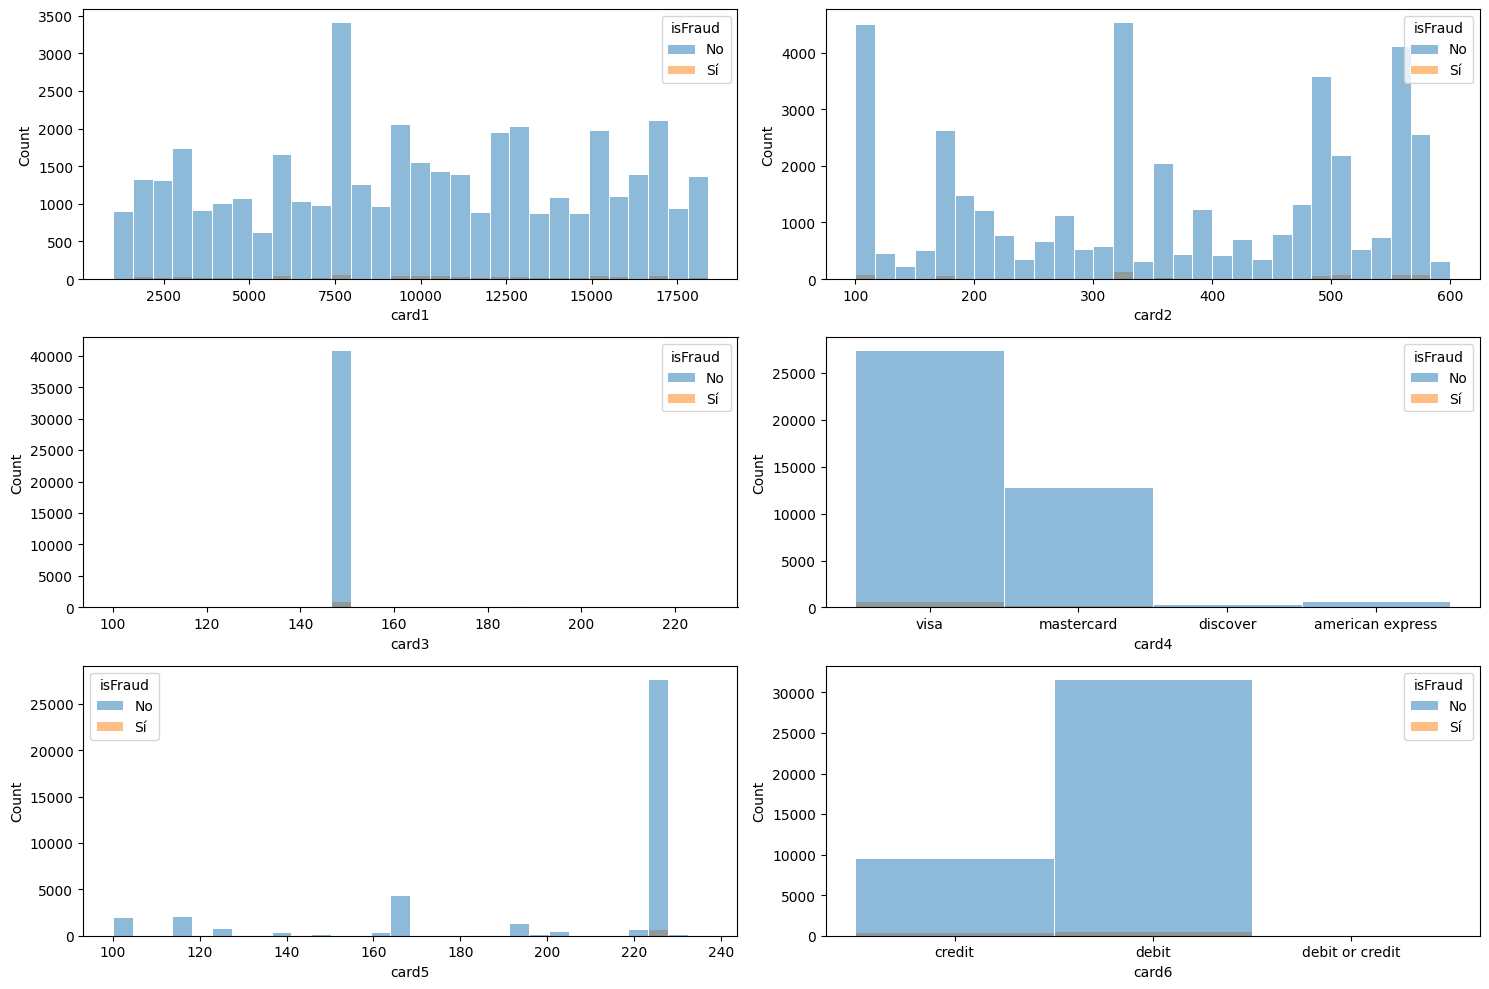

In [120]:
cards = ['card1', 'card2', 'card3', 'card4', 'card5',
       'card6']


# Crear subplots para cada rango de valor
fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharey=False, tight_layout=True)

# Iterar sobre los subplots y los rangos
for i, ax in enumerate(axs.flatten()):
        sns.histplot(data=df_train, x=cards[i], bins=30,
                     edgecolor="white", linewidth=0.7, log_scale=False, ax=ax,hue='isFraud')

# Ajustar el espacio entre subplots y mostrar la figura
plt.tight_layout()
plt.show()
    

### **C1-C14**

**C1-C14**: conteo, como cuántas direcciones están asociadas con la tarjeta de pago, etc.
- "Conteos de variables C1-C15: ¿Serían como recuentos de números de teléfono, direcciones de correo electrónico, nombres asociados con el usuario? Tu suposición es buena, además de dispositivos, direcciones IP, dirección de facturación, etc. También son para el comprador y el destinatario, lo que duplica el número."

In [139]:
c_valores = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10',
       'C11', 'C12', 'C13', 'C14']

In [141]:
df_train[c_valores].dtypes

C1     float64
C2     float64
C3     float64
C4     float64
C5     float64
C6     float64
C7     float64
C8     float64
C9     float64
C10    float64
C11    float64
C12    float64
C13    float64
C14    float64
dtype: object

In [142]:
df_train[c_valores].describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,42357.000000,42357.000000,42357.000000,42357.000000,42357.000000,42357.000000,42357.000000,42357.000000,42357.000000,42357.000000,42357.000000,42357.000000,42357.000000,42357.000000
mean,9.813065,9.435512,0.000496,1.765847,6.184007,7.367590,0.077650,1.158840,4.888779,1.064263,7.239653,0.173171,31.029228,7.399155
std,56.732480,60.935296,0.023297,36.757931,27.345060,42.077417,7.394755,22.825275,17.233356,21.590958,44.171312,9.993922,105.613743,33.715381
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,1.000000
75%,3.000000,3.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,13.000000,2.000000
max,1867.000000,2378.000000,2.000000,1151.000000,335.000000,1151.000000,1152.000000,1721.000000,193.000000,1889.000000,1549.000000,1549.000000,1674.000000,785.000000


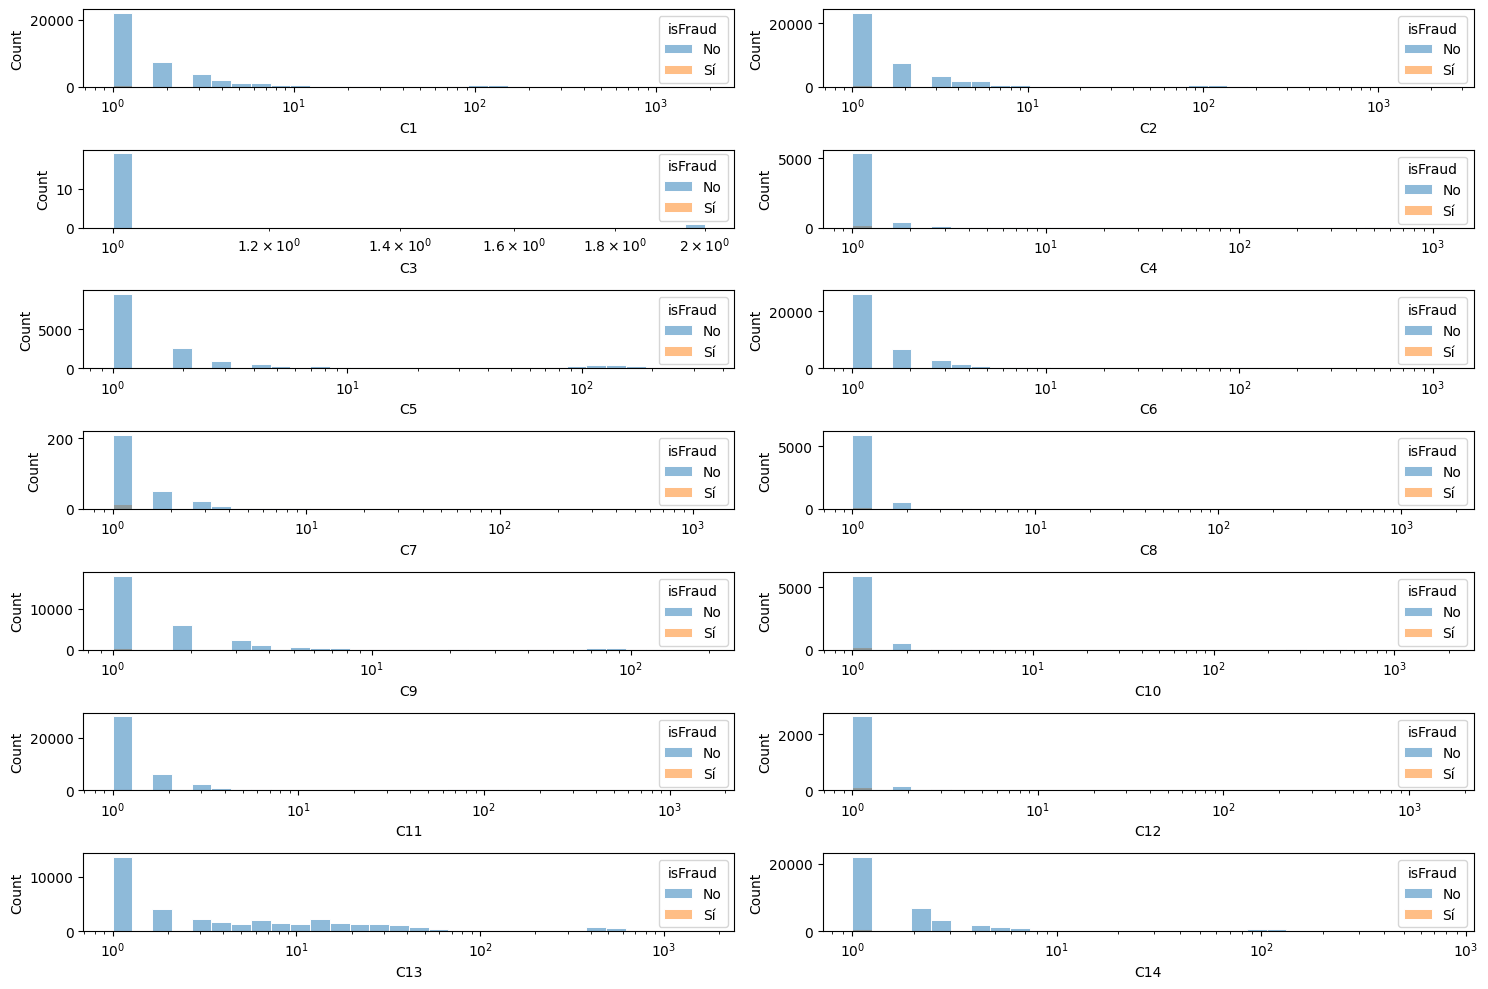

In [147]:


# Crear subplots para cada rango de valor
fig, axs = plt.subplots(7, 2, figsize=(15, 10), sharey=False, tight_layout=True)

# Iterar sobre los subplots y los rangos
for i, ax in enumerate(axs.flatten()):
        sns.histplot(data=df_train, x=c_valores[i], bins=30,
                     edgecolor="white", linewidth=0.7, log_scale=True, ax=ax,hue='isFraud')

# Ajustar el espacio entre subplots y mostrar la figura
plt.tight_layout()
plt.show()
    

### Análisis Bivariado

### Características Numeŕicas

In [121]:
df_train.columns

Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'addr1',
       'addr2', 'P_emaildomain', 'card1', 'card2', 'card3', 'card4', 'card5',
       'card6', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10',
       'C11', 'C12', 'C13', 'C14', 'TransactionAmt_Range'],
      dtype='object')

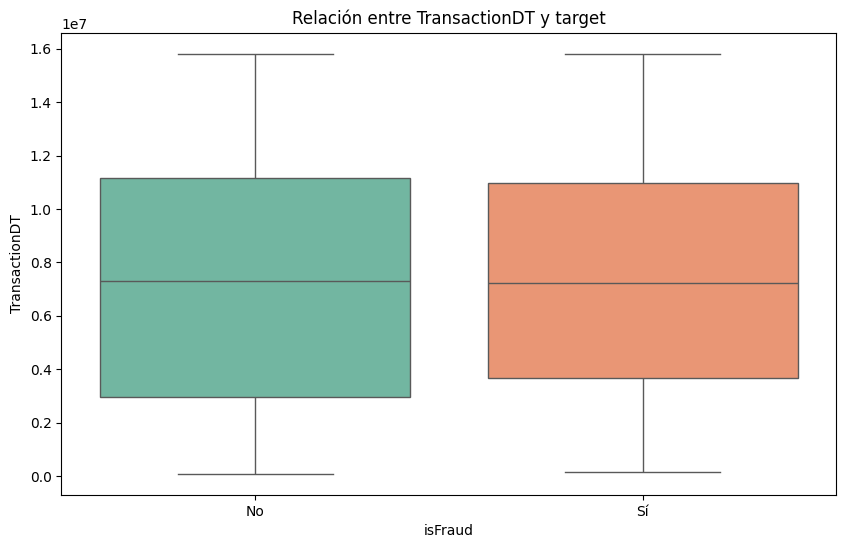

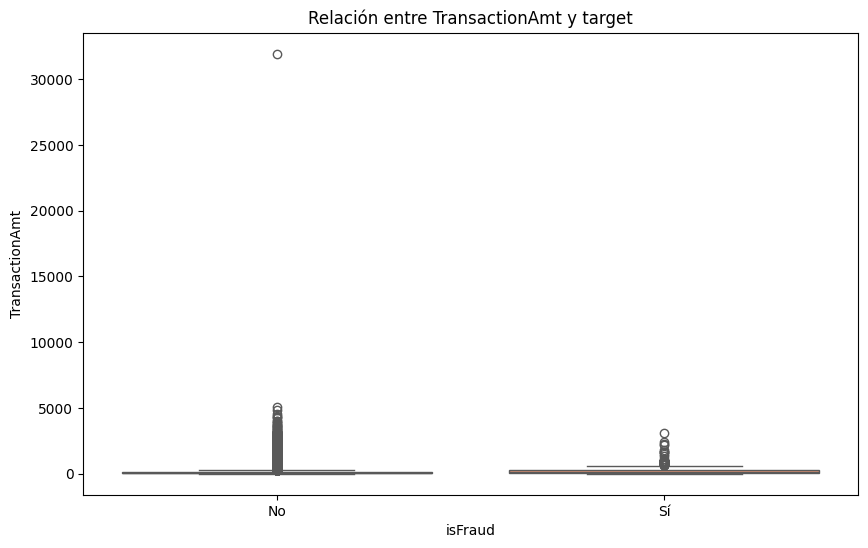

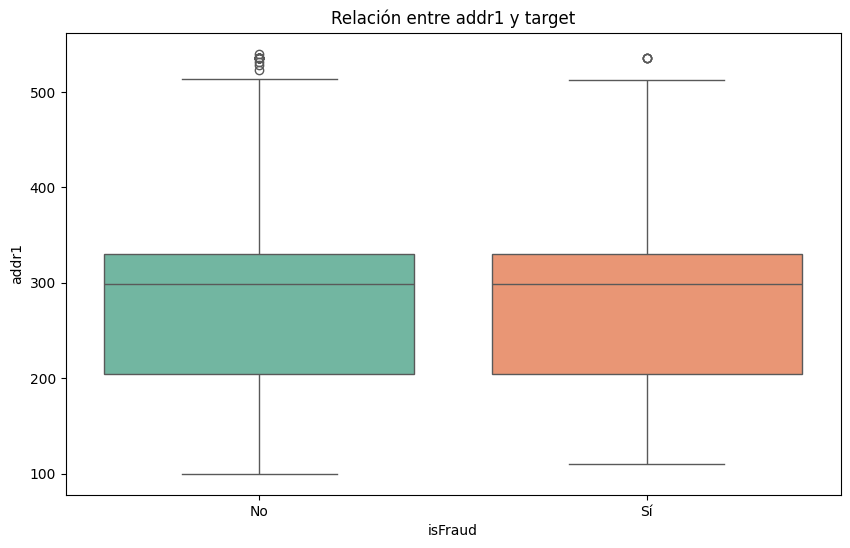

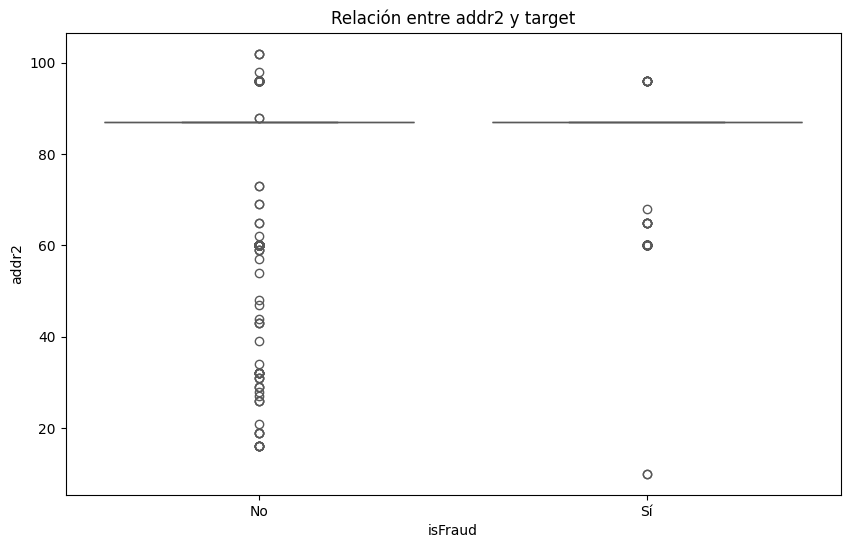

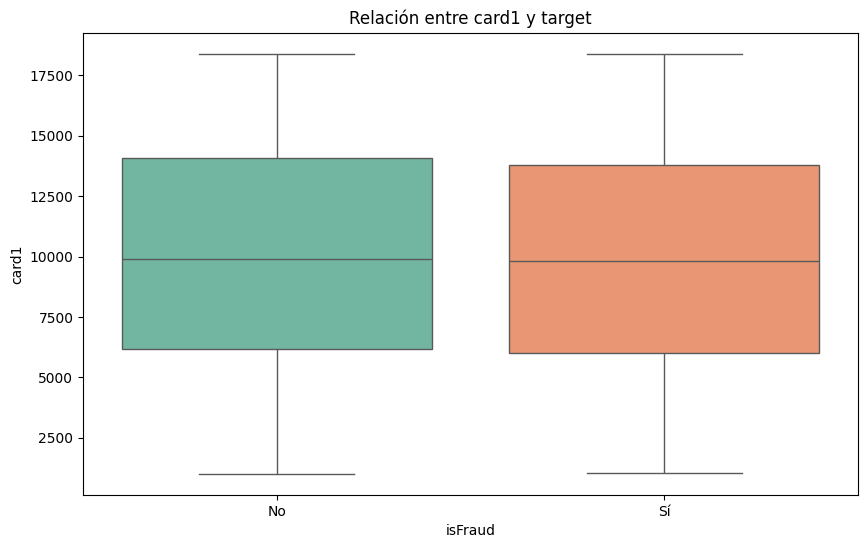

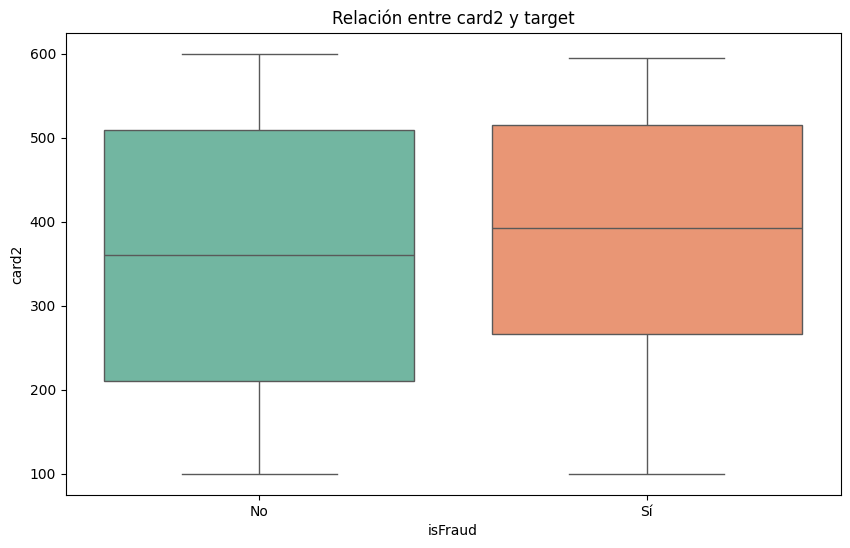

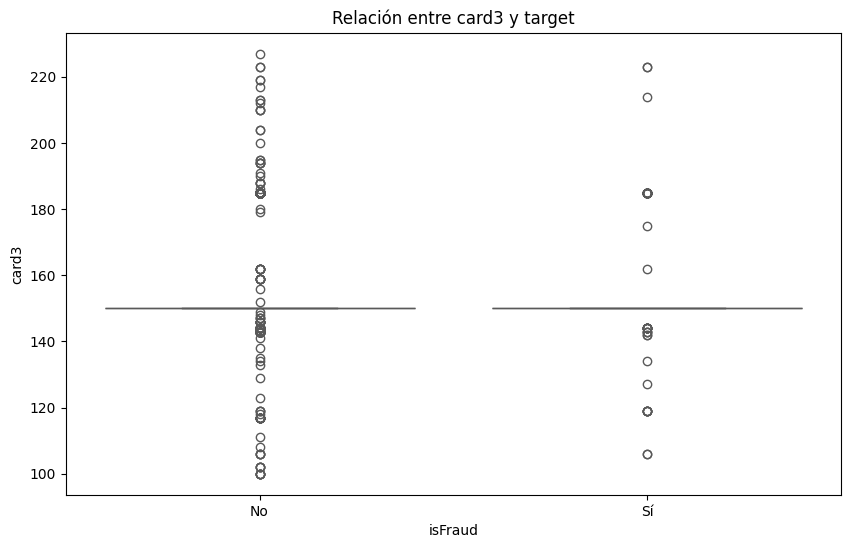

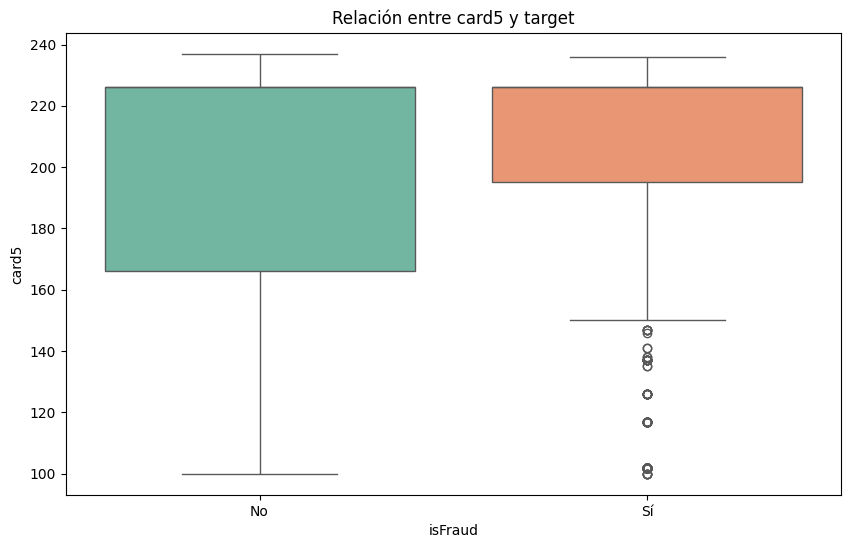

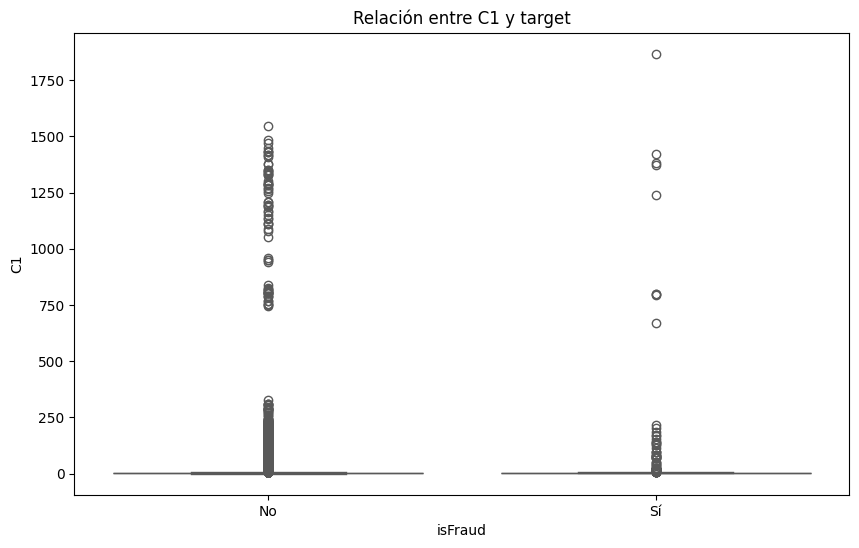

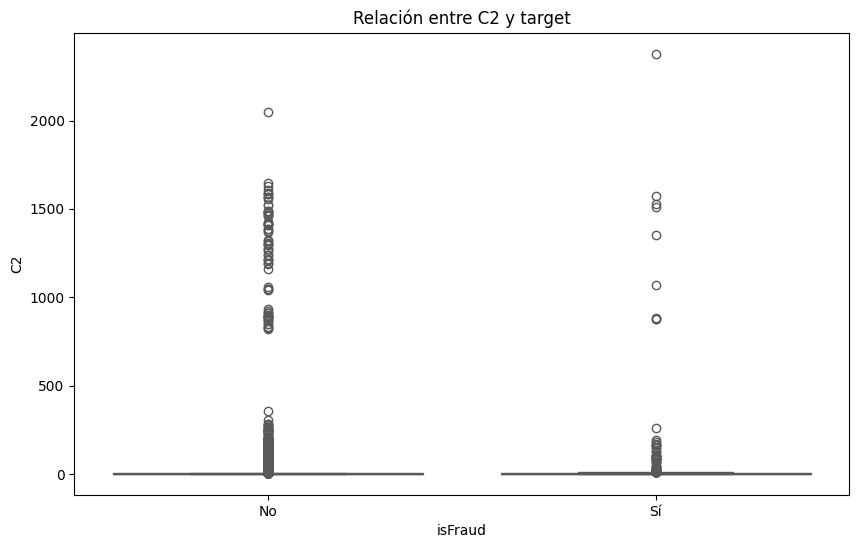

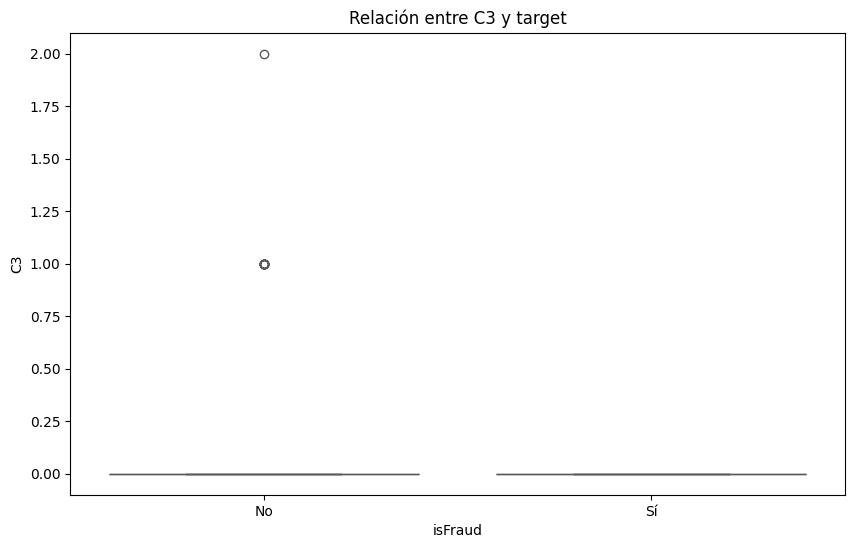

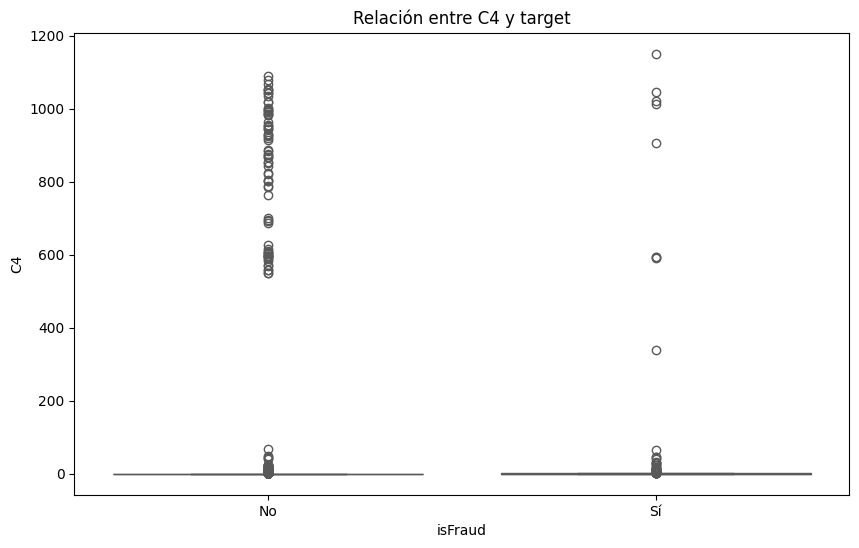

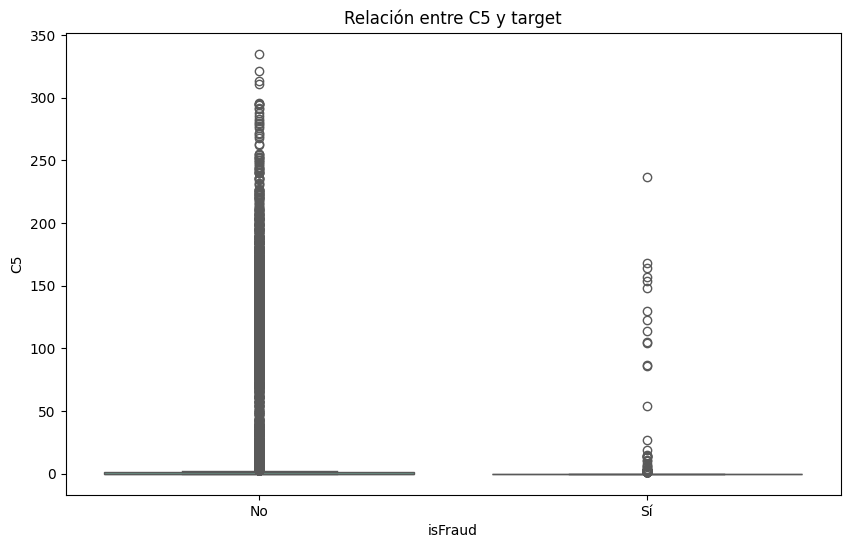

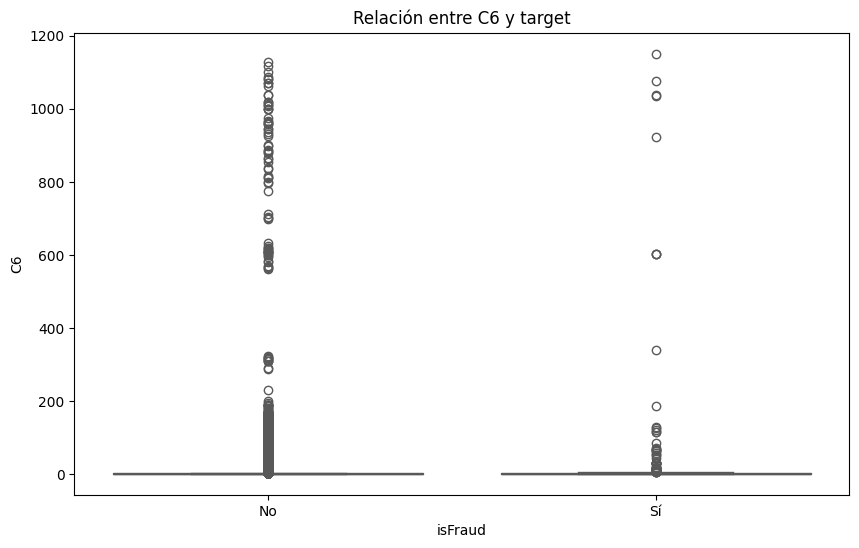

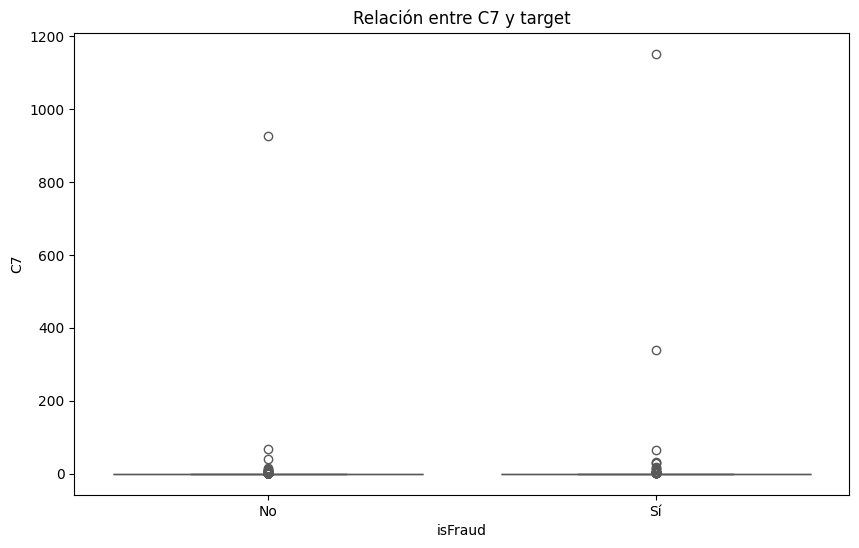

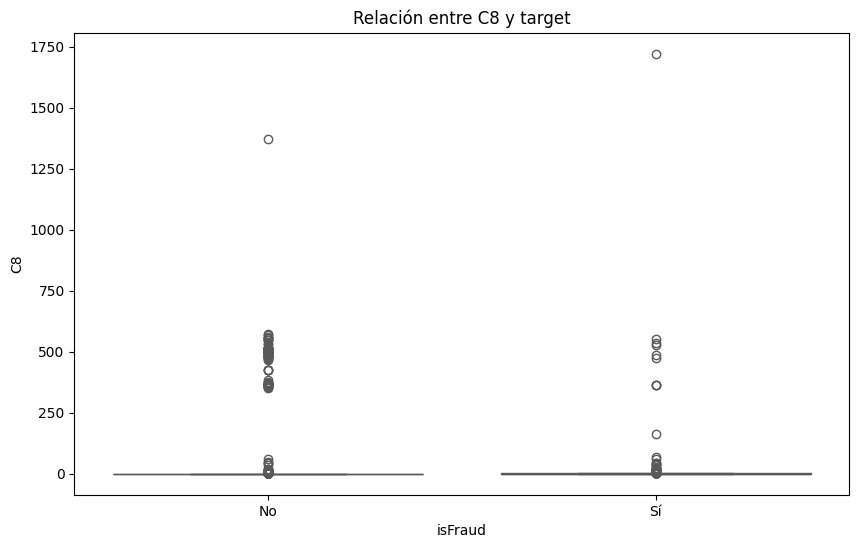

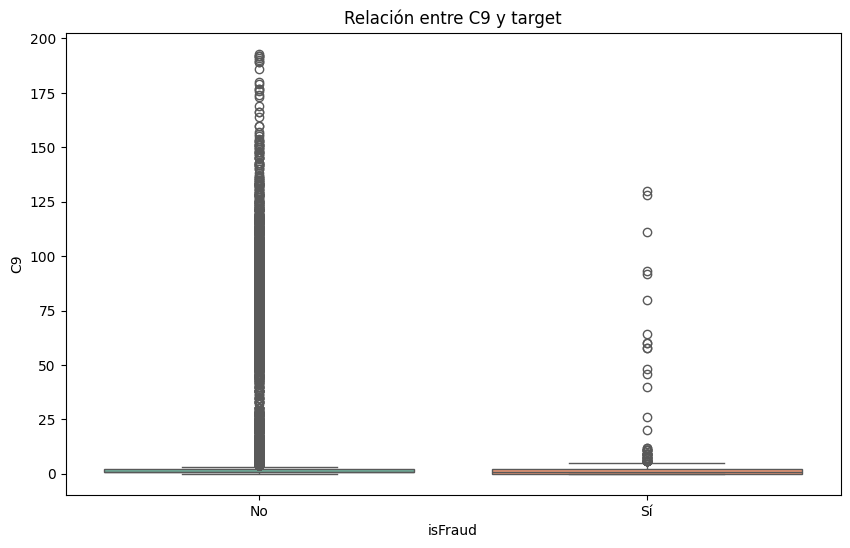

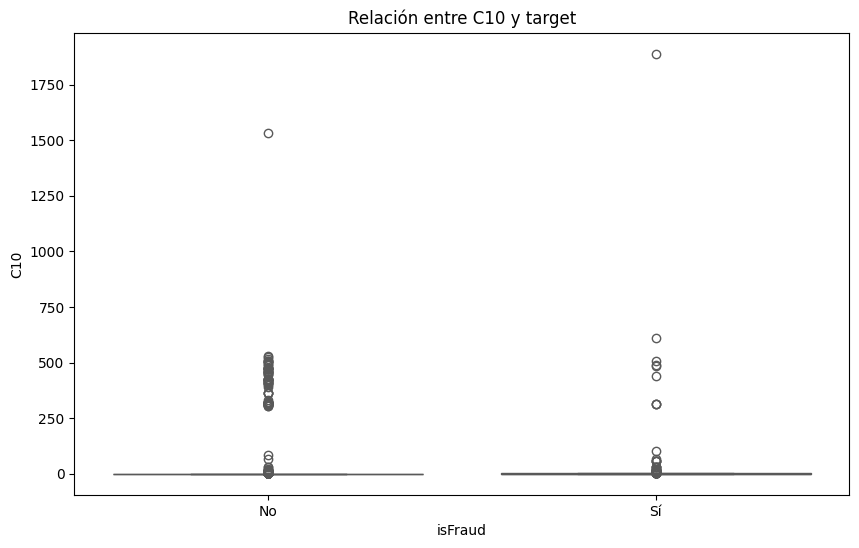

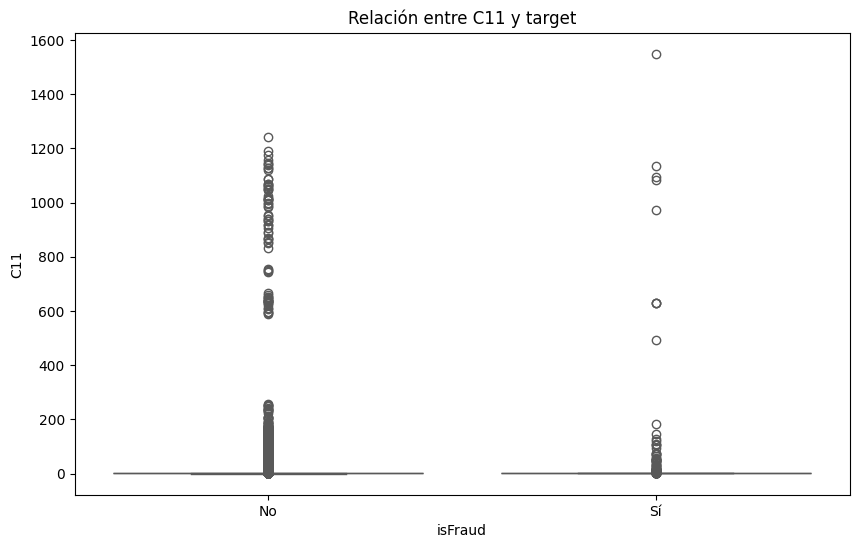

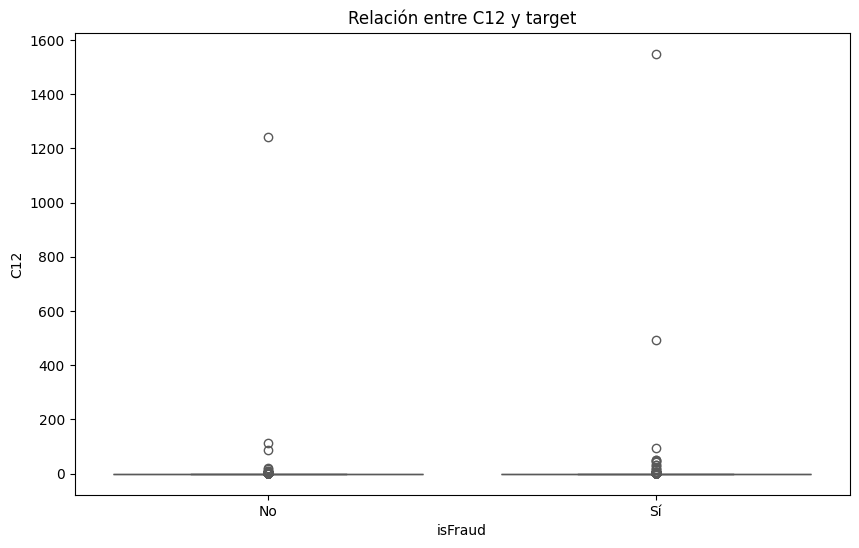

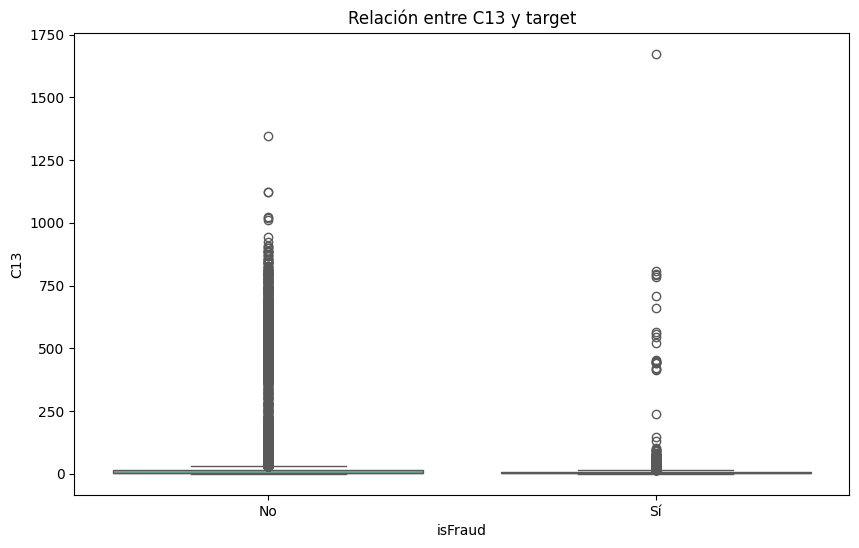

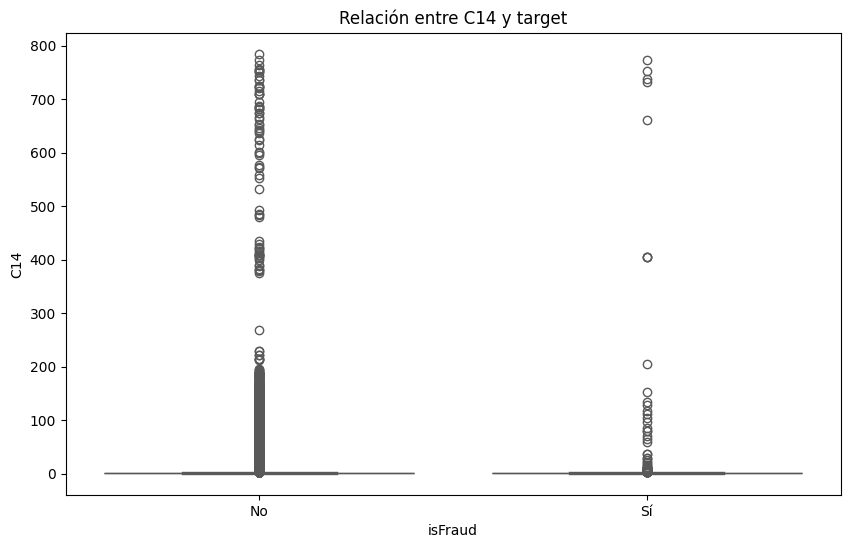

In [122]:
palette = 'Set2'  # Puedes cambiar 'Set2' por otras paletas como 'Set1', 'Set3', 'Dark2', etc.

# Generar los boxplots con la paleta de colores genérica
for column in df_train.select_dtypes(include=['number']).columns:
    if column != 'isFraud':
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='isFraud', y=column, data=df_train, hue='isFraud', palette=palette, legend=False)
        plt.title(f'Relación entre {column} y target')
        plt.show()


**Observaciones:**
Las características numéricas se analizaron en relación con la variable objetivo "isFraud". Se observó lo siguiente:

- TransactionDT: Tanto las transacciones fraudulentas como las no fraudulentas presentan distribuciones similares.
- TransactionAmt: Se observa una mayor diferencia debido a la presencia de valores atípicos y diferentes distribuciones entre los casos con fraude y sin fraude.
- Addr1:Las direcciones por región son similares tanto para los casos con fraude como para los casos sin fraude.
- Add2: Las direcciones por país son similares tanto para los casos con fraude como para los casos sin fraude.
- Card1: Las distribución con fraude y no fraude son similares
- Card2 y Card5: Hay diferencia entre ellas significativas 

In [123]:
df_stat = df_train.groupby('isFraud').describe(include='number').T.round(2)
df_stat['diferencia_absoluta'] = df_stat['No'] - df_stat['Sí']
df_stat['diferencia_relativa %'] = round(abs((df_stat['diferencia_absoluta'] / df_stat.sum(axis=1)) * 100),2)

df_stat.sort_values(by='diferencia_relativa %',ascending=False)

isFraud   No   Sí  diferencia_absoluta  diferencia_relativa %
C4  75%  0.0  1.0                 -1.0                    inf
C8  75%  0.0  1.0                 -1.0                    inf
C11 min  0.0  1.0                 -1.0                    inf
C1  min  0.0  1.0                 -1.0                    inf
C10 75%  0.0  1.0                 -1.0                    inf
...      ...  ...                  ...                    ...
C12 25%  0.0  0.0                  0.0                    NaN
    50%  0.0  0.0                  0.0                    NaN
    75%  0.0  0.0                  0.0                    NaN
C13 min  0.0  0.0                  0.0                    NaN
C14 min  0.0  0.0                  0.0                    NaN

[176 rows x 4 columns]

In [124]:
df_stat.loc[df_stat.index.get_level_values(1) == 'mean'].sort_values(by='diferencia_relativa %',ascending=False)

,isFraud,No,Sí,diferencia_absoluta,diferencia_relativa %
C7,mean,0.04,1.75,-1.71,2137.50
C12,mean,0.11,2.60,-2.49,1131.82
C10,mean,0.93,6.53,-5.60,301.08
C8,mean,1.02,6.67,-5.65,276.96
C4,mean,1.61,8.20,-6.59,204.66
C2,mean,9.22,18.17,-8.95,48.54
C11,mean,7.12,12.23,-5.11,35.88
C1,mean,9.66,16.17,-6.51,33.70
C5,mean,6.28,2.16,4.12,32.80
C6,mean,7.27,11.32,-4.05,27.85


** Observación**
- Se observa que las diferencias relativas en los valores medios de las características numéricas son menores al 1%, excepto en "TransactionAmt" que es el del 21.69%, lo cual podría deberse a la presencia de valores atípicos y card2 que es del 2.88%, 
Esto podŕia indicar una dificultad en el entrenamiento con las características numéricas, ya que sus distribuciones no son muy difrentes


### Características Categóricas 

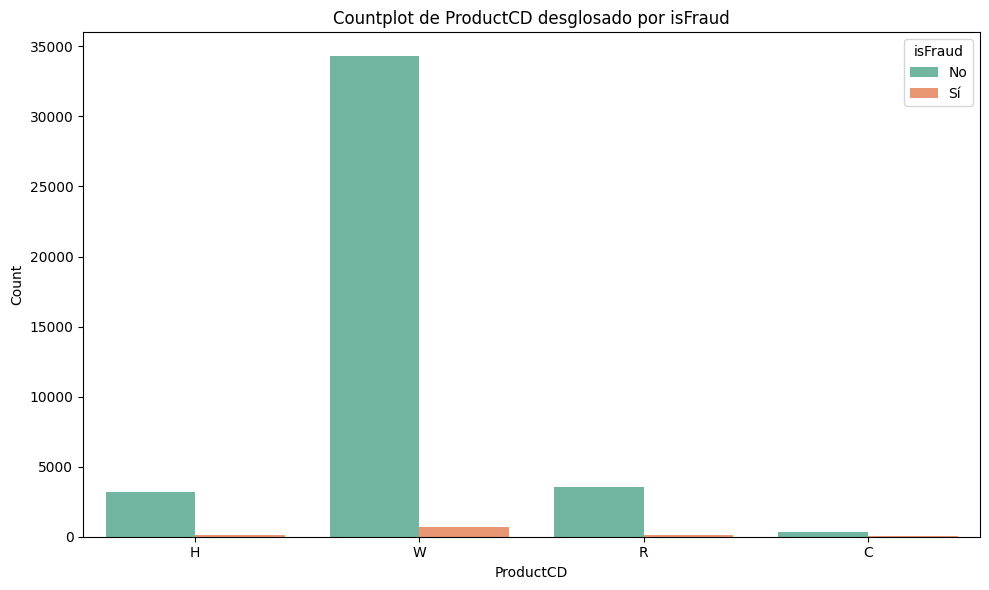

isFraud       No   Sí
ProductCD            
W          34289  668
H           3180  155
R           3578  151
C            303   33


In [125]:
count_table = pd.crosstab(index=df_train['ProductCD'], columns=df_train['isFraud'])
count_table = count_table.sort_values(by='Sí',ascending=False)
# Configurar el estilo y tamaño del gráfico
plt.figure(figsize=(10, 6))

# Crear el countplot utilizando seaborn
sns.countplot(data=df_train, x='ProductCD', hue='isFraud', palette='Set2')

# Ajustar el formato de las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=0)

# Añadir título y etiquetas de los ejes
plt.title('Countplot de ProductCD desglosado por isFraud')
plt.xlabel('ProductCD')
plt.ylabel('Count')

# Mostrar el gráfico con leyenda
plt.legend(title='isFraud')
plt.tight_layout()
plt.show()

# Mostrar la tabla de conteo desglosada por ProductCD y isFraud
print(count_table)

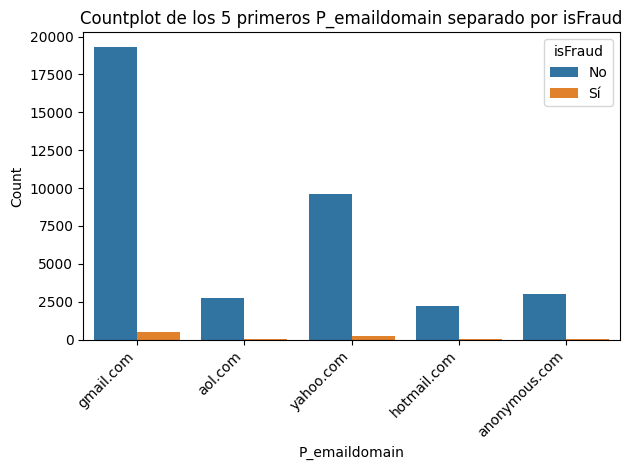

In [126]:

top_5_domains = df_train['P_emaildomain'].value_counts().head(5).index
df_top_5 = df_train[df_train['P_emaildomain'].isin(top_5_domains)]
sns.countplot(data=df_top_5, x='P_emaildomain', hue='isFraud')
plt.xticks(rotation=45, ha='right')
plt.title('Countplot de los 5 primeros P_emaildomain separado por isFraud')
plt.xlabel('P_emaildomain')
plt.ylabel('Count')
plt.legend(title='isFraud')
plt.tight_layout()
plt.show()


In [127]:
count_table = pd.crosstab(index=df_train['P_emaildomain'], columns=df_train['isFraud'])
count_table = count_table.sort_values(by='Sí',ascending=False).head(5)
count_table

isFraud,No,Sí
P_emaildomain,,
gmail.com,19317,512
yahoo.com,9581,225
aol.com,2710,51
anonymous.com,3017,50
hotmail.com,2187,47


In [128]:

# Crear tabla de contingencia (crosstab) desglosando por P_emaildomain y isFraud
count_table = pd.crosstab(index=df_train['P_emaildomain'], columns=df_train['isFraud'])

# Ordenar la tabla por la cantidad de fraudes (isFraud == 1)
count_table = count_table.sort_values(by='Sí', ascending=False).head(5)

# Calcular el porcentaje en función del total de cada columna
count_table_percentage = count_table.apply(lambda x: x / x.sum() * 100, axis=0).round(2)

# Mostrar la tabla de contingencia y su porcentaje
print("Tabla de Contingencia :")
print(count_table)
print("\nPorcentaje en función del total de cada columna:")
print(count_table_percentage)

Tabla de Contingencia :
isFraud           No   Sí
P_emaildomain            
gmail.com      19317  512
yahoo.com       9581  225
aol.com         2710   51
anonymous.com   3017   50
hotmail.com     2187   47

Porcentaje en función del total de cada columna:
isFraud           No     Sí
P_emaildomain              
gmail.com      52.47  57.85
yahoo.com      26.03  25.42
aol.com         7.36   5.76
anonymous.com   8.20   5.65
hotmail.com     5.94   5.31


In [129]:

# Crear tabla de contingencia (crosstab) desglosando por ProductCD y isFraud
count_table = pd.crosstab(index=df_train['ProductCD'], columns=df_train['isFraud'])

# Ordenar la tabla por la cantidad de fraudes (isFraud == 1)
count_table = count_table.sort_values(by='Sí', ascending=False)

# Calcular el porcentaje en función del total de cada columna
count_table_percentage = count_table.apply(lambda x: x / x.sum() * 100, axis=0).round(2)

# Mostrar la tabla de contingencia y su porcentaje
print("Tabla de Contingencia :")
print(count_table)
print("\nPorcentaje en función del total de cada columna:")
print(count_table_percentage)

Tabla de Contingencia :
isFraud       No   Sí
ProductCD            
W          34289  668
H           3180  155
R           3578  151
C            303   33

Porcentaje en función del total de cada columna:
isFraud       No     Sí
ProductCD              
W          82.92  66.34
H           7.69  15.39
R           8.65  15.00
C           0.73   3.28


### Cards Categóricas

In [130]:
df_train[cards].select_dtypes('object')

,card4,card6
294161,visa,credit
34825,mastercard,credit
374859,visa,debit
545712,visa,debit
518262,mastercard,debit
...,...,...
460423,visa,debit
364785,mastercard,debit
157056,visa,debit
523532,visa,debit


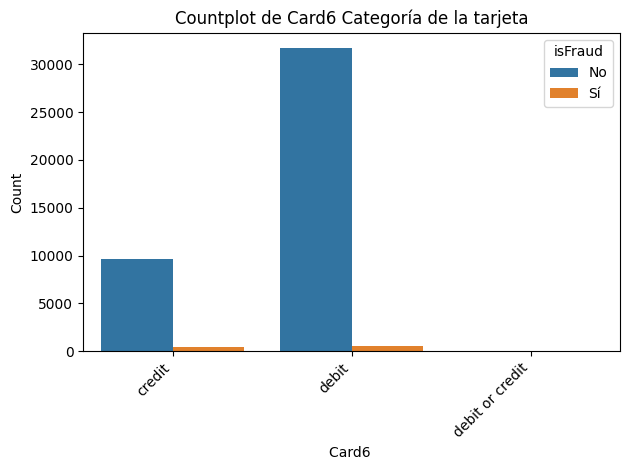

In [131]:

sns.countplot(data=df_train, x='card6', hue='isFraud')
plt.xticks(rotation=45, ha='right')
plt.title('Countplot de Card6 Categoría de la tarjeta' )
plt.xlabel('Card6 ')
plt.ylabel('Count')
plt.legend(title='isFraud')
plt.tight_layout()
plt.show()


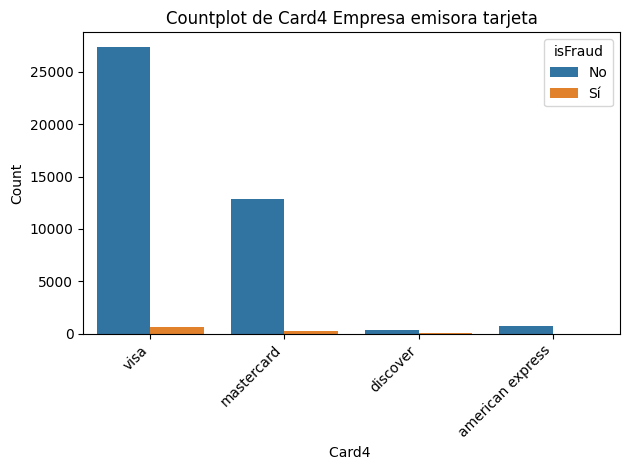

In [132]:


sns.countplot(data=df_train, x='card4', hue='isFraud')
plt.xticks(rotation=45, ha='right')
plt.title('Countplot de Card4 Empresa emisora tarjeta' )
plt.xlabel('Card4 ')
plt.ylabel('Count')
plt.legend(title='isFraud')
plt.tight_layout()
plt.show()


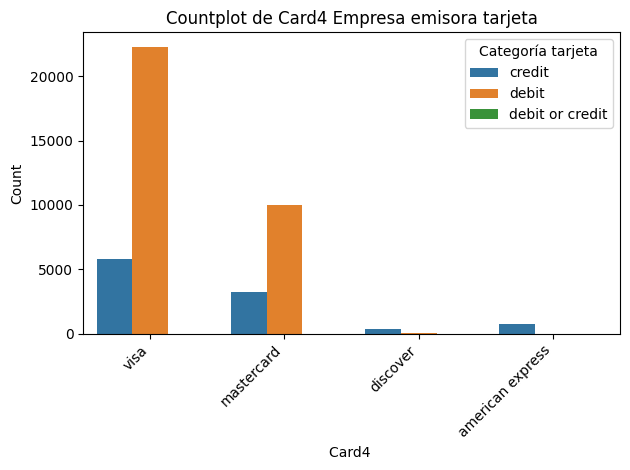

In [133]:


sns.countplot(data=df_train, x='card4', hue='card6')
plt.xticks(rotation=45, ha='right')
plt.title('Countplot de Card4 Empresa emisora tarjeta' )
plt.xlabel('Card4 ')
plt.ylabel('Count')
plt.legend(title='Categoría tarjeta')
plt.tight_layout()
plt.show()


In [134]:

# Crear tabla de contingencia (crosstab) desglosando por ProductCD y isFraud
count_table = pd.crosstab(index=df_train['card4'], columns=df_train['isFraud'])

# Ordenar la tabla por la cantidad de fraudes (isFraud == 1)
count_table = count_table.sort_values(by='Sí', ascending=False)

# Calcular el porcentaje en función del total de cada columna
count_table_percentage = count_table.apply(lambda x: x / x.sum() * 100, axis=0).round(2)

# Mostrar la tabla de contingencia y su porcentaje
print("Tabla de Contingencia :")
print(count_table)
print("\nPorcentaje en función del total de cada columna:")
print(count_table_percentage)

Tabla de Contingencia :
isFraud              No   Sí
card4                       
visa              27413  675
mastercard        12881  297
discover            319   24
american express    737   11

Porcentaje en función del total de cada columna:
isFraud              No     Sí
card4                         
visa              66.30  67.03
mastercard        31.15  29.49
discover           0.77   2.38
american express   1.78   1.09


- La mayoría de los fraude es con 67% con la empresa Visa, seguida por la mastecard con un 29%, seguidas las otras empresas

In [135]:

# Crear tabla de contingencia (crosstab) desglosando por ProductCD y isFraud
count_table = pd.crosstab(index=df_train['card6'], columns=df_train['isFraud'])

# Ordenar la tabla por la cantidad de fraudes (isFraud == 1)
count_table = count_table.sort_values(by='Sí', ascending=False)

# Calcular el porcentaje en función del total de cada columna
count_table_percentage = count_table.apply(lambda x: x / x.sum() * 100, axis=0).round(2)

# Mostrar la tabla de contingencia y su porcentaje
print("Tabla de Contingencia :")
print(count_table)
print("\nPorcentaje en función del total de cada columna:")
print(count_table_percentage)

Tabla de Contingencia :
isFraud             No   Sí
card6                      
debit            31713  580
credit            9635  427
debit or credit      2    0

Porcentaje en función del total de cada columna:
isFraud             No    Sí
card6                       
debit            76.69  57.6
credit           23.30  42.4
debit or credit   0.00   0.0


- Los valores de fraude con debito es de 57.6% y con credito de 42%, la diferencia es de un 15%, podría ser significativo.

**Observación**
- ProductCD: El producto con el mayor porcentaje de fraude es "W", representando el 66.8 % del total de productos con fraude. Le sigue el producto "H" con un 15.19 %, luego "R" con un 14.7 %, y en menor medida el producto "C" con solo un 3.31 %.
- El correo con mayor incidencia de fraude es el de Gmail, alcanzando un 57.96 % del total. Le sigue Yahoo con un 25.33 %, mientras que los demás proveedores de correo tienen una incidencia menor. Es probable que el alto porcentaje de fraudes en cuentas de Gmail se deba a su amplia base de usuario.

### Correlción entre las variables numéricas

In [151]:
df_train['isFraud'] = df_train['isFraud'].replace({'No': 0, 'Sí': 1})

/tmp/ipykernel_13590/163350230.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['isFraud'] = df_train['isFraud'].replace({'No': 0, 'Sí': 1})


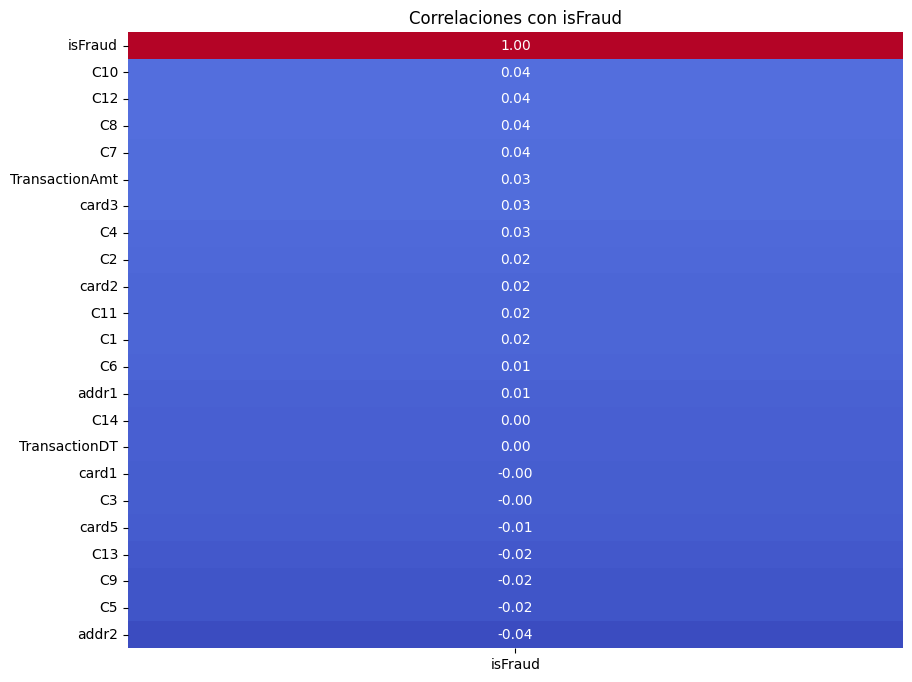

In [159]:
correlation_matrix = df_train.select_dtypes(exclude=['object']).corr()

# Filtrar para obtener solo las correlaciones con la columna 'isfraud'
isfraud_correlation = correlation_matrix[['isFraud']].sort_values(by='isFraud', ascending=False)

# Visualización de las correlaciones con 'isfraud'
plt.figure(figsize=(10, 8))
sns.heatmap(isfraud_correlation, annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
plt.title('Correlaciones con isFraud')
plt.show()

**Observación** 
- Se pude gráfica de correlación entre las variables numéricas se conclute que en general las variables no estan correlacionadas

Generamos un archivo csv con Dataframe de los datos de entrenamiento, el que se usara para la segunda parte del proyecto, "Limpieza y preprocesamiento de los datos"

In [137]:
dir_data_interim = '../data/interim/'
ruta_archivo_completa = os.path.join(dir_data_interim, 'train')

df_train.to_csv(ruta_archivo_completa, index=False, encoding='utf-8')

### Conclusiones 

Durante el análisis exploratorio de datos, se realizaron varias observaciones significativas sobre el dataset:

- El dataset original contiene más de medio millón de registros, por lo que se aplicó un método de muestreo estratificado para obtener una muestra representativa y manejable.
- Se seleccionaron las características más relevantes para el objetivo de detección de fraude en este primer análisis.
- Se identificaron columnas con valores nulos, se evaluó su cantidad y porcentaje, así como la correlación entre ellas. Se decidió eliminar aquellas columnas con un alto porcentaje de valores nulos para simplificar el análisis.
- Se encontraron y eliminaron valores duplicados, que eran escasos en comparación con el tamaño total del dataset.
- Del análisis univariado:
  - La columna objetivo "isFraud" muestra un desbalance con un 97.6% de registros no fraudulentos, lo cual debe considerarse al entrenar cualquier modelo.
  - La columna "TransactionAmt", que representa los montos de transacción, presenta distribuciones distintas según los rangos de valores y algunos valores atípicos, sugiriendo la segmentación para el entrenamiento del modelo.
  - La columna "TransactionDT" muestra una distribución uniforme en los datos.
  - La columna "ProductCD", que indica el producto de la transacción, muestra que casi el 82.71% de las transacciones corresponden al producto "W", seguido por "R" con 8.75%, "H" con 7.76%, y "C" con 0.78%.
  - La columna "addr1", que representa la dirección por región de los compradores, muestra que el 9.48% de las transacciones provienen de la región "299", seguida por "204", "325", "264" y otras regiones con menor porcentaje.
  - La columna "addr2", que representa la dirección por país, indica que el país con más transacciones tiene el código "84", representando el 99% del total de transacciones en el dataset.
  - La columna "P_emaildomain", que representa los proveedores de correo electrónico de los compradores, muestra que Gmail tiene la mayor incidencia de fraude con un 57.96% del total, seguido por Yahoo con un 25.33%. Otros proveedores tienen una incidencia menor de fraude.

- Del análisis bivariado:
  - TransactionDT: Tanto las transacciones fraudulentas como las no fraudulentas presentan distribuciones similares.
  - TransactionAmt: Se observa una mayor diferencia debido a la presencia de valores atípicos y diferentes distribuciones entre los casos con fraude y sin fraude.
  - Addr1:Las direcciones por región son similares tanto para los casos con fraude como para los casos sin fraude.
  - Add2: Las direcciones por país son similares tanto para los casos con fraude como para los casos sin fraude.
  - Se observa que las diferencias relativas entre si es fraude o no en los valores medios de las características numéricas son menores al 1%, excepto en "TransactionAmt", lo cual podría deberse a la presencia de valores atípicos.
Esto podŕia indicar una dificultad en el entrenamiento con las características numéricas, ya que sus distribuciones no son muy difrentes
  - ProductCD: El producto con el mayor porcentaje de fraude es "W", representando el 66.8 % del total de productos con fraude. Le sigue el producto "H" con un 15.19 %, luego "R" con un 14.7 %, y en menor medida el producto "C" con solo un 3.31 %.
  - El correo con mayor incidencia de fraude es el de Gmail, alcanzando un 57.96 % del total. Le sigue Yahoo con un 25.33 %, mientras que los demás proveedores de correo tienen una incidencia menor. Es probable que el alto porcentaje de fraudes en cuentas de Gmail se deba a su amplia base de usuario.

  

Estas conclusiones proporcionan una base sólida para entender la distribución de los datos y guiarán el preprocesamiento adicional y la construcción de modelos en futuros análisis.
